In [50]:
import numpy as np
import pandas as pd
import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller
from arch.unitroot import engle_granger

import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style="whitegrid")

pd.core.common.is_list_like = pd.api.types.is_list_like
from pandas_datareader import data as pdr
import datetime
import yfinance as yf
yf.pdr_override()
from hurst import compute_Hc

import warnings
warnings.filterwarnings('ignore')


In [51]:
def stationarity_test(X, cutoff=0.05):
    pvalue = adfuller(X)[1]
    if pvalue < cutoff:
        print('p-value = ' + str(pvalue) + ' The series ' + X.name +' is likely stationary.')
    else:
        print('p-value = ' + str(pvalue) + ' The series ' + X.name +' is likely non-stationary.')

def find_cointegrated_pairs(data):
    n = data.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    # trends = ['n', 'c', 'ct', 'ctt']
    # trends = ['c']
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            S1 = data[keys[i]]
            S2 = data[keys[j]]
            # result = engle_granger(S1, S2, trend=trend)
            result = engle_granger(S1, S2)
            test_statistic = result.stat
            pvalue = result.pvalue
            score_matrix[i, j] = test_statistic
            pvalue_matrix[i, j] = pvalue
            if pvalue < 0.03:
                pairs.append((keys[i], keys[j]))
    return score_matrix, pvalue_matrix, pairs, pvalue

def halflife_(z_array):
    z_lag = np.roll(z_array,1)
    z_lag[0] = 0
    z_ret = z_array - z_lag
    z_ret[0] = 0

    #adds intercept terms to X variable for regression
    z_lag2 = sm.add_constant(z_lag)

    model = sm.OLS(z_ret,z_lag2)
    res = model.fit()

    halflife = -np.log(2) / res.params[1]
    return halflife

## Get crypto data

In [52]:
from pathlib import Path

ROOT = Path('data/crypto')

In [53]:
def convert_unix_to_date(df: pd.DataFrame) -> pd.Series:
    date = df['Date'].copy()
    date.loc[df['tradecount'].isna()] = pd.to_datetime(df.loc[df['tradecount'].isna(), 'Unix'], unit='s')
    # date.
    date = pd.to_datetime(date)  # оставшаяся часть данных была в формате строки
    return date

btc_usdt_file = ROOT / 'Binance_BTCUSDT_1h.csv'
eth_usdt_file = ROOT / 'Binance_ETHUSDT_1h.csv'
bnb_usdt_file = ROOT / 'Binance_BNBUSDT_1h.csv'

link_usdt_file = ROOT / 'Binance_LINKUSDT_1h.csv'
ltc_usdt_file = ROOT / 'Binance_LTCUSDT_1h.csv'
neo_usdt_file = ROOT / 'Binance_NEOUSDT_1h.csv'

qtum_usdt_file = ROOT / 'Binance_QTUMUSDT_1h.csv'

df_btc = pd.read_csv(btc_usdt_file, skiprows=1)
df_eth = pd.read_csv(eth_usdt_file, skiprows=1)
df_bnb = pd.read_csv(bnb_usdt_file, skiprows=1)

df_link = pd.read_csv(link_usdt_file, skiprows=1)
df_ltc = pd.read_csv(ltc_usdt_file, skiprows=1)
df_neo = pd.read_csv(neo_usdt_file, skiprows=1)

df_qtum = pd.read_csv(qtum_usdt_file, skiprows=1)

In [54]:
df_btc['Date'] = df_btc['Date'].apply(lambda x: str(x).split('.')[0])
df_eth['Date'] = df_eth['Date'].apply(lambda x: str(x).split('.')[0])
df_bnb['Date'] = df_bnb['Date'].apply(lambda x: str(x).split('.')[0])
df_link['Date'] = df_link['Date'].apply(lambda x: str(x).split('.')[0])
df_ltc['Date'] = df_ltc['Date'].apply(lambda x: str(x).split('.')[0])
df_neo['Date'] = df_neo['Date'].apply(lambda x: str(x).split('.')[0])
df_qtum['Date'] = df_qtum['Date'].apply(lambda x: str(x).split('.')[0])

In [55]:
df_btc['Date'] = convert_unix_to_date(df_btc)
df_eth['Date'] = convert_unix_to_date(df_eth)
df_bnb['Date'] = convert_unix_to_date(df_bnb)

df_link['Date'] = convert_unix_to_date(df_link)
df_ltc['Date'] = convert_unix_to_date(df_ltc)
df_neo['Date'] = convert_unix_to_date(df_neo)

df_qtum['Date'] = convert_unix_to_date(df_qtum)

In [56]:
dataframes = {'btc': df_btc, 'eth': df_eth, 'bnb': df_bnb, 
              'link': df_link, 'ltc': df_ltc, 'neo': df_neo, 'qtum': df_qtum,} 

from functools import reduce

for suffix, df in dataframes.items():
    df.columns = [f'{col}_{suffix}' if col != 'Date' else col for col in df.columns]

merged_df = reduce(lambda left, right: pd.merge(left, right, on='Date', how='outer'), dataframes.values())

In [57]:
merged_df.drop_duplicates(inplace=True)
df = merged_df.sort_values(by='Date')
df = df.set_index('Date')
df.dropna(inplace=True)

In [58]:
columns_to_keep = [col for col in df.columns if col.startswith('Close_')]
df = df[columns_to_keep]

Before performing cointegration test split data into training and test

In [59]:
start = '2021-06-10'
end = '2024-05-03'
train = df.loc["2021-06-10 00:00:00":"2023-06-10 23:00:00"]
validation = df.loc["2023-06-10 00:00:00":"2023-12-31 23:00:00"]
test = df.loc["2023-12-31 23:00:00":]

In [60]:
scores, pvalues, pairs, pvalue = find_cointegrated_pairs(train)
print(pvalues)

[[1.00000000e+00 8.88012679e-02 1.88946860e-01 1.38525803e-01
  9.41522923e-02 8.96222209e-02 1.37357519e-02]
 [1.00000000e+00 1.00000000e+00 1.42167875e-02 2.83939433e-01
  1.77031926e-01 2.19827822e-01 6.30051232e-02]
 [1.00000000e+00 1.00000000e+00 1.00000000e+00 1.94670586e-01
  1.34811735e-01 2.48148571e-01 7.49214121e-02]
 [1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
  5.78087014e-02 1.89025138e-02 8.24841724e-04]
 [1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
  1.00000000e+00 8.90320749e-02 2.07785219e-02]
 [1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
  1.00000000e+00 1.00000000e+00 3.28871757e-02]
 [1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
  1.00000000e+00 1.00000000e+00 1.00000000e+00]]


In [61]:
pairs

[('Close_btc', 'Close_qtum'),
 ('Close_eth', 'Close_bnb'),
 ('Close_link', 'Close_neo'),
 ('Close_link', 'Close_qtum'),
 ('Close_ltc', 'Close_qtum')]

In [62]:
pvalue = 1
pair = ('','')
for pair in pairs:
    _, _, _, pvalue_pair = find_cointegrated_pairs(train[[pair[0], pair[1]]])
    if pvalue > pvalue_pair:
        pvalue = pvalue_pair
        pair = (pair[0], pair[1])

In [63]:
pairs = [pair]

In [64]:
x_col = [x[0] for x in pairs]
y_col = [y[1] for y in pairs]

x_col_log = [f'{x}_log' for x in x_col]
y_col_log = [f'{y}_log' for y in y_col]

df_filtered = df[list(set(x_col + y_col))]

In [65]:
cols = list(set(x_col + y_col))

for col in cols:
    df_filtered[f'{col}_log'] = np.log(df_filtered[col])

In [66]:
df = df_filtered

## Split data

In [81]:
start = '2021-06-10'
end = '2024-05-03'
train = df.loc["2021-06-10 00:00:00":"2022-12-01 23:00:00"]
validation = df.loc["2022-12-01 00:00:00":"2023-03-01 23:00:00"]
test = df.loc["2023-03-01 23:00:00":]

In [82]:
train.shape, validation.shape, test.shape

((12954, 4), (2184, 4), (6407, 4))

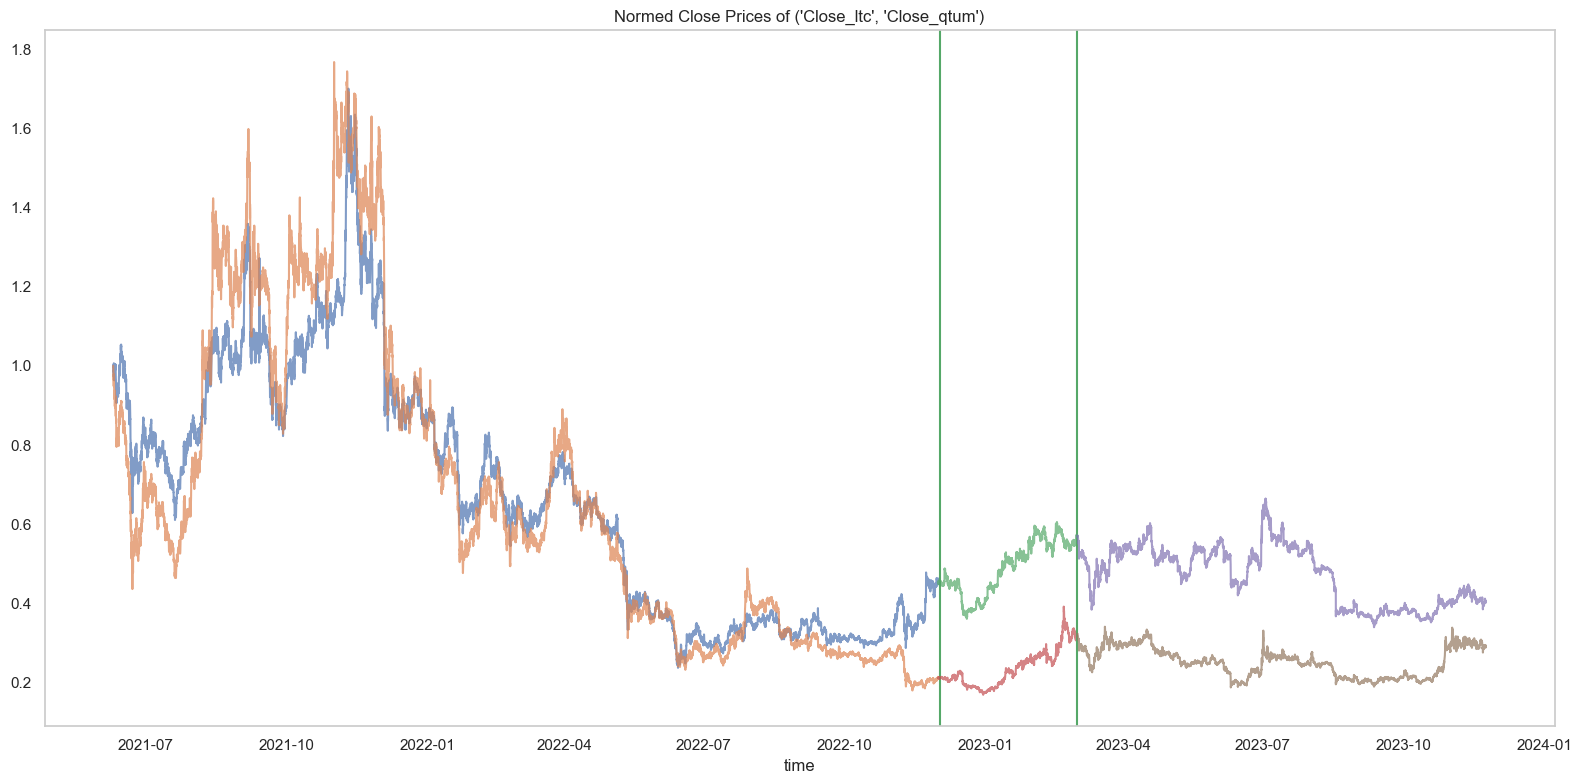

In [83]:
# n_rows = 2
# n_cols = 3

n_rows = 1
n_cols = 1

plt.figure(figsize=(16, 8))

for i, pair in enumerate(pairs):
    plt.subplot(n_rows, n_cols, i+1)
    plt.plot(train[f'{pair[0]}'] / train[f'{pair[0]}'].iloc[0], alpha=0.7, label=f'{pair[0].upper()}, Train')
    plt.plot(train[f'{pair[1]}'] / train[f'{pair[1]}'].iloc[0], alpha=0.7, label=f'{pair[1].upper()}, Train')
    plt.axvline(train.index[-1], color='C2')

    plt.plot(validation[f'{pair[0]}'] / train[f'{pair[0]}'].iloc[0], alpha=0.7, label=f'{pair[0].upper()}, Validation')
    plt.plot(validation[f'{pair[1]}'] / train[f'{pair[1]}'].iloc[0], alpha=0.7, label=f'{pair[1].upper()}, Validation')
    plt.axvline(validation.index[-1], color='C2')

    plt.plot(test[f'{pair[0]}'] / train[f'{pair[0]}'].iloc[0], alpha=0.7, label=f'{pair[0].upper()}, Test')
    plt.plot(test[f'{pair[1]}'] / train[f'{pair[1]}'].iloc[0], alpha=0.7, label=f'{pair[1].upper()}, Test')

    plt.grid()
    # plt.legend()
    plt.title(f'Normed Close Prices of {pair}')
    plt.xlabel('time')

plt.tight_layout()
plt.show()

## Kalman Filter

In [84]:
from pykalman import KalmanFilter
import numpy as np
from tqdm import tqdm

In [85]:
pair[0]

'Close_ltc'

Calculate spread for validation

In [86]:
y = train[f'{pair[0]}_log']
x = train[f'{pair[1]}_log']

delta = 1e-3
trans_cov = delta / (1 - delta) * np.eye(2) # How much random walk wiggles
obs_mat = np.expand_dims(np.vstack([[x], [np.ones(len(x))]]).T, axis=1)

kf = KalmanFilter(n_dim_obs=1, n_dim_state=2, # y is 1-dimensional, (alpha, beta) is 2-dimensional
                  initial_state_mean=[0.95,0.95],
                  initial_state_covariance=np.ones((2, 2)),# 2x2 matrix of ones for covariance matrix estimate
                  transition_matrices=np.eye(2),
                  observation_matrices=obs_mat,
                  observation_covariance=2,
                  transition_covariance=trans_cov)

state_means_gm, state_covs_gm = kf.filter(y.values)

y_new = validation[f'{pair[0]}_log'].values
x_new = validation[f'{pair[1]}_log'].values
# y_new = validation['Close_btc_log'].values
# x_new = validation['Close_eth_log'].values

spreads = []
predicted_spreads = []

first_spread = y_new[0] - state_means_gm[-1, 0] * x_new[0] - state_means_gm[-1, 1]
predicted_spreads.append(first_spread)

filtered_state_mean = state_means_gm[-1]
filtered_state_covariance = state_covs_gm[-1]


for t in tqdm(range(len(x_new) - 1)):
    obs_mat = np.array([[x_new[t], 1.0]]) # For current observation
    
    # Update Kalman filter
    filtered_state_mean, filtered_state_covariance = kf.filter_update(
        filtered_state_mean, filtered_state_covariance, observation=y_new[t], observation_matrix=obs_mat)

    current_spread = y_new[t] - (filtered_state_mean[0] * x_new[t] + filtered_state_mean[1])
    spreads.append(current_spread)

    predicted_spread_t1 = y_new[t + 1] - filtered_state_mean[0] * x_new[t + 1] - filtered_state_mean[1]
    predicted_spreads.append(predicted_spread_t1)

100%|██████████| 2183/2183 [00:01<00:00, 1499.28it/s]


In [87]:
pairs

[('Close_ltc', 'Close_qtum')]

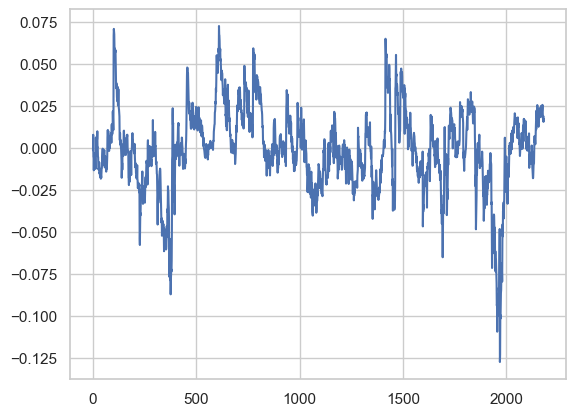

In [88]:
plt.plot(predicted_spreads)

Calculate spread for test

In [89]:
y_new = test[f'{pair[0]}_log'].values
x_new = test[f'{pair[1]}_log'].values
# y_new = test['Close_btc_log'].values
# x_new = test['Close_eth_log'].values

spreads_test = []
predicted_spreads_test = []

# Use last state_mean to predict spread for current observation
first_spread = y_new[0] - filtered_state_mean[0] * x_new[0] - filtered_state_mean[1]
predicted_spreads_test.append(first_spread)

for t in tqdm(range(len(x_new) - 1)):
    obs_mat = np.array([[x_new[t], 1.0]])
    
    filtered_state_mean, filtered_state_covariance = kf.filter_update(
        filtered_state_mean, filtered_state_covariance, observation=y_new[t], observation_matrix=obs_mat)

    current_spread = y_new[t] - (filtered_state_mean[0] * x_new[t] + filtered_state_mean[1])
    spreads_test.append(current_spread)

    predicted_spread_t1 = y_new[t + 1] - filtered_state_mean[0] * x_new[t + 1] - filtered_state_mean[1]
    predicted_spreads_test.append(predicted_spread_t1)

100%|██████████| 6406/6406 [00:04<00:00, 1437.62it/s]


In [90]:
validation['spread_kalman'] = predicted_spreads
test['spread_kalman'] = predicted_spreads_test

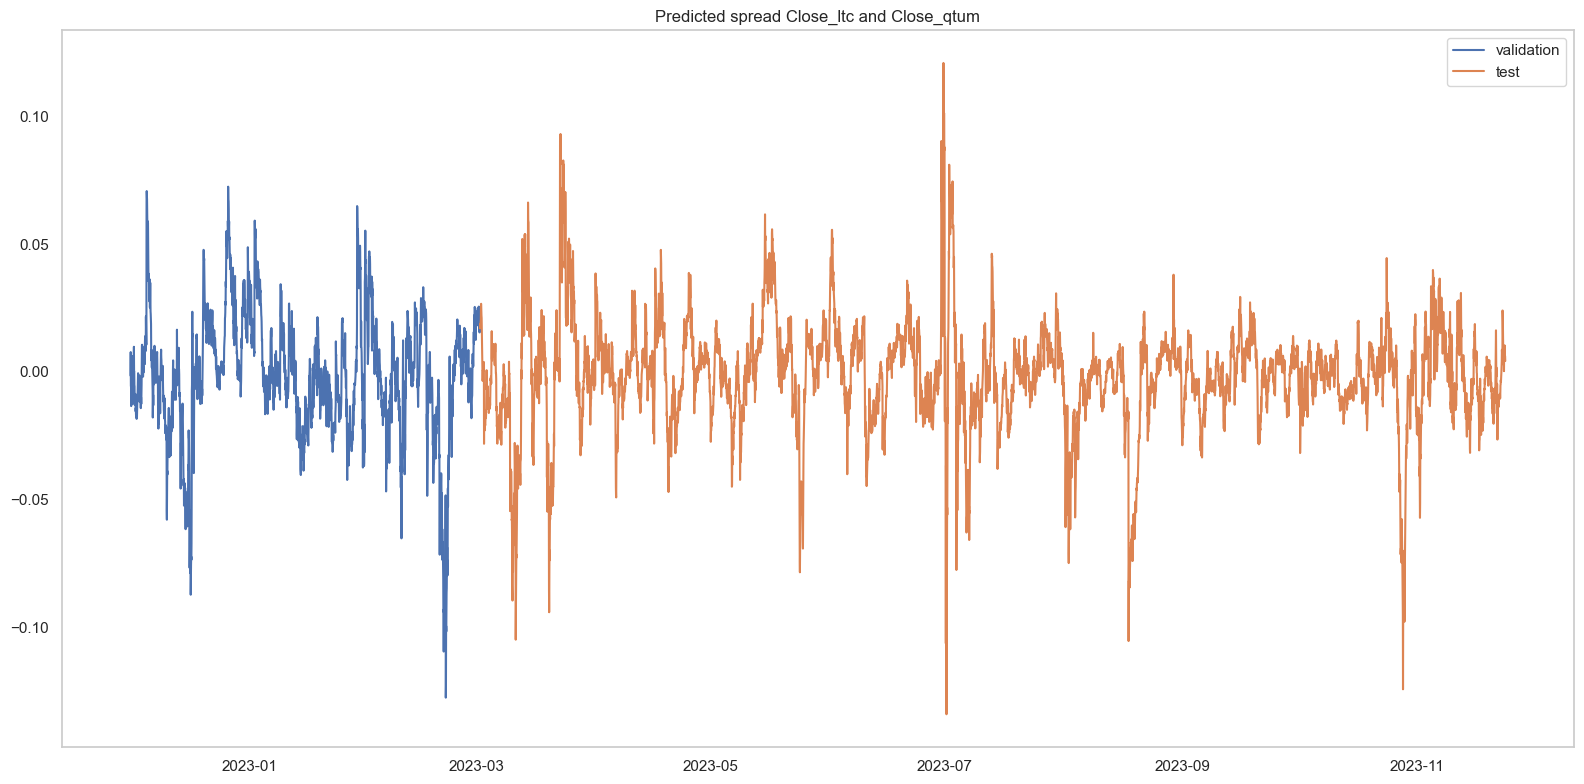

In [91]:
n_rows = 1
n_cols = 1

plt.figure(figsize=(16, 8))

for i, pair in enumerate(pairs):
    plt.subplot(n_rows, n_cols, i+1)

    plt.plot(validation['spread_kalman'], label='validation')
    plt.plot(test['spread_kalman'], label='test')
    plt.legend()
    plt.grid()
    plt.title(f'Predicted spread {pair[0]} and {pair[1]}')

plt.tight_layout()
plt.show()

## Strategy

In [92]:
def pair_strategy(curr_trade: list, pos: float, index: int, spread: pd.Series, data: pd.DataFrame, t_cols: list) -> tuple:
    if spread >= data[t_cols[0]][index] and pos == 0:  # open long
        pos = amount
        desicion = 'open'
    elif spread <= -data[t_cols[0]][index] and pos == 0:  # open short
        pos = -amount
        desicion = 'open'
    elif (spread <= data[t_cols[1]][index] and pos > 0) or (spread >= -data[t_cols[1]][index] and pos < 0):  # close
        pos = 0
        desicion = 'close'
    else:
        desicion = 'hold'
    return desicion, pos

In [93]:
def plot_results(info: pd.DataFrame, price_cols: str, t_cols: list) -> None:    
    num_plots = 4

    plt.figure(figsize=(20, 14))
    
    plt.subplot(num_plots, 1, 1)
    plt.plot(info[price_cols[0]], label=price_cols[0])
    plt.legend(loc='upper left')
    plt.twinx()
    plt.plot(info[price_cols[1]], label=price_cols[1], color='C1')
    plt.legend(loc='upper right')
    plt.grid()
    plt.title(f'Prices of {price_cols[0]} and {price_cols[1]}')

    plt.subplot(num_plots, 1, 2)
    plt.plot(info.index, info['real_pnl'])
    plt.grid()
    plt.title(f'Pnl {price_cols[0]} and {price_cols[1]}')
    
    plt.subplot(num_plots, 1, 3)
    plt.plot(info.index, info['position'])
    plt.grid()
    plt.title('Position')

    plt.subplot(num_plots, 1, 4)
    plt.plot(info.index, info['spread'])
    plt.scatter(info[info['trades'] == 'open'].index, info[info['trades'] == 'open']['spread'], color='green', label='open pos')
    plt.scatter(info[info['trades'] == 'close'].index, info[info['trades'] == 'close']['spread'], color='red', label='close pos')
    if len(t_cols) == 2:
        plt.plot(info.index, info[t_cols[0]], color='green', alpha=0.5, label=t_cols[0])
        plt.plot(info.index, -1 * info[t_cols[0]], color='green', alpha=0.5)
        plt.plot(info.index, info[t_cols[1]], color='red', alpha=0.5, label=t_cols[1])
        plt.plot(info.index, -1 * info[t_cols[1]], color='red', alpha=0.5)
    else:
        colors = ['green', 'green', 'red']
        for index, col in enumerate(t_cols):
            plt.plot(info.index, info[col], color=colors[index], alpha=0.5, label=col)

    plt.grid()
    plt.legend()
    plt.title(f'Spread of {price_cols[0]} and {price_cols[1]}')

    plt.show()

In [94]:
def calc_pnl(last_amount, curr_amount, pos):
    if pos > 0:
        pnl = np.sum(curr_amount - last_amount)
    elif pos < 0:
        pnl = np.sum(last_amount - curr_amount)
    else:
        pnl = 0
    return pnl

# Пока оставлю, но в будущем удалю
def calc_sharpe(pnl: pd.Series) -> float:
    # посчитаем шарп как дельту пнлей, а не через доходности, так как у нас нет формируемого портфеля активов
    
    returns = pnl.diff().fillna(value=0)
    mean_return = returns.mean()
    std = returns.std()
    sharpe = (mean_return) / std * np.sqrt(365 * 25)
    return sharpe

# В будущем удалю
def calc_max_drawdown(pnl: pd.Series) -> float:
    max_pnl = 0
    index_max_pnl = 0
    max_drawdown = 0
    start_index = 0
    end_index = 0
    for index, value in enumerate(pnl.values):
        if value > max_pnl:
            max_pnl = value
            index_max_pnl = index
        else:
            curr_drawdown = max_pnl - value
            if curr_drawdown > max_drawdown:
                max_drawdown = curr_drawdown
                start_index = index_max_pnl
                end_index = index

    return max_drawdown

In [95]:
def run_pair_strategy(df: pd.DataFrame, price_cols: list, spread_col: str, amount: float, w, strategy: 'function', t_cols: list = None, verbose: bool = True, viz: bool = True) -> tuple:
    if t_cols is None:
        t_cols = ['open_t', 'close_t']
    spread_values = df[spread_col].to_numpy()
    amounts_vector = np.array([amount, -w * amount])
    prices = df[price_cols].to_numpy()
    prices_to_order = prices * amounts_vector  # цены для покупки / продажи, учитывая сторону сделки
    
    pnls = []
    open_pnls = []
    trades = []
    all_pos = []
    last_trade = None
    pos = 0

    for index, spread in enumerate(spread_values):
        curr_trade = prices_to_order[index]
        curr_opnl = 0
        curr_pnl = 0
        
        desicion, new_pos = strategy(curr_trade, pos, index, spread, df, t_cols)

        # считаем либо close pnl, либо open pnl
        if desicion == 'open':
            last_trade = curr_trade
            pos = new_pos
        elif desicion == 'close':
            curr_pnl = calc_pnl(last_trade, curr_trade, pos)
            last_trade = None
            pos = 0
        else:
            curr_opnl = calc_pnl(last_trade, curr_trade, pos)
        
        open_pnls.append(curr_opnl)
        pnls.append(curr_pnl)
        trades.append(desicion)
        all_pos.append(pos)
        

    pnls = np.array(pnls)
    open_pnls = np.array(open_pnls)
    trades = np.array(trades)
    
    total_df = df[price_cols].copy()
    total_df['pnl'] = pnls
    total_df['open_pnl'] = open_pnls
    total_df['trades'] = trades
    total_df['position'] = all_pos
    total_df['spread'] = df[spread_col]
    total_df['real_pnl'] = np.cumsum(pnls) + open_pnls
    total_df[t_cols] = df[t_cols]
    
    
    if verbose:
        final_pnl = total_df['real_pnl'].iloc[-1]
        pnl_per_day = final_pnl / (total_df.index[-1] - total_df.index[0]).days
        trades = (total_df['trades'] != 'hold').sum() // 2  # считаем одним трейдом пару открытие-закрытие позиции
        sharpe_ratio = calc_sharpe(total_df['real_pnl'])
        max_dd = calc_max_drawdown(total_df['real_pnl'])
        pnl_to_max_dd = final_pnl / max_dd
        summary = {f'final_pnl {pair}': final_pnl, 'pnl_per_day': pnl_per_day, 'trades': trades, 'max_dd': max_dd, 
                   'sharpe_ratio': sharpe_ratio, 'pnl_to_max_dd': pnl_to_max_dd}
        print(*[f'{key}: {round(value, 4)}' for key, value in summary.items()], sep='\n')
    
    if viz:
        plot_results(total_df, price_cols, t_cols)
        
    return total_df

In [96]:
def startegy_metrics(total_df, data):
    final_pnl = total_df['real_pnl'].iloc[-1]
    final_pnl_test = data['real_pnl'].iloc[-1]

    trades = (total_df['trades'] != 'hold').sum() // 2  # считаем одним трейдом пару открытие-закрытие позиции
    trades_test = (data['trades'] != 'hold').sum() // 2  # считаем одним трейдом пару открытие-закрытие позиции

    sharpe_ratio = calc_sharpe(total_df['real_pnl'])
    sharpe_ratio_test = calc_sharpe(data['real_pnl'])

    max_dd = calc_max_drawdown(total_df['real_pnl'])
    max_dd_test = calc_max_drawdown(data['real_pnl'])

    pnl_to_max_dd = final_pnl / max_dd
    pnl_to_max_dd_test = final_pnl_test / max_dd_test

    summary = {f'final_pnl {pair}': str(round(final_pnl, 4)) + ' ' + str(round(final_pnl_test, 4)), 
                'trades': str(trades) + ' ' + str(trades_test), 
                'max_dd': str(round(max_dd, 4)) + ' ' + str(round(max_dd_test, 4)), 
                'sharpe_ratio': str(round(sharpe_ratio, 4)) + ' ' + str(round(sharpe_ratio_test, 4)), 
                'pnl_to_max_dd': str(round(pnl_to_max_dd, 4)) + ' ' + str(round(pnl_to_max_dd_test, 4))}
    print(*[f'{key}: {value}' for key, value in summary.items()], sep='\n')
    print("\n")

## Test strategy

Validation

final_pnl ('Close_ltc', 'Close_qtum'): -39.041
pnl_per_day: -0.4338
trades: 17
max_dd: 47.211
sharpe_ratio: -5.1785
pnl_to_max_dd: -0.8269


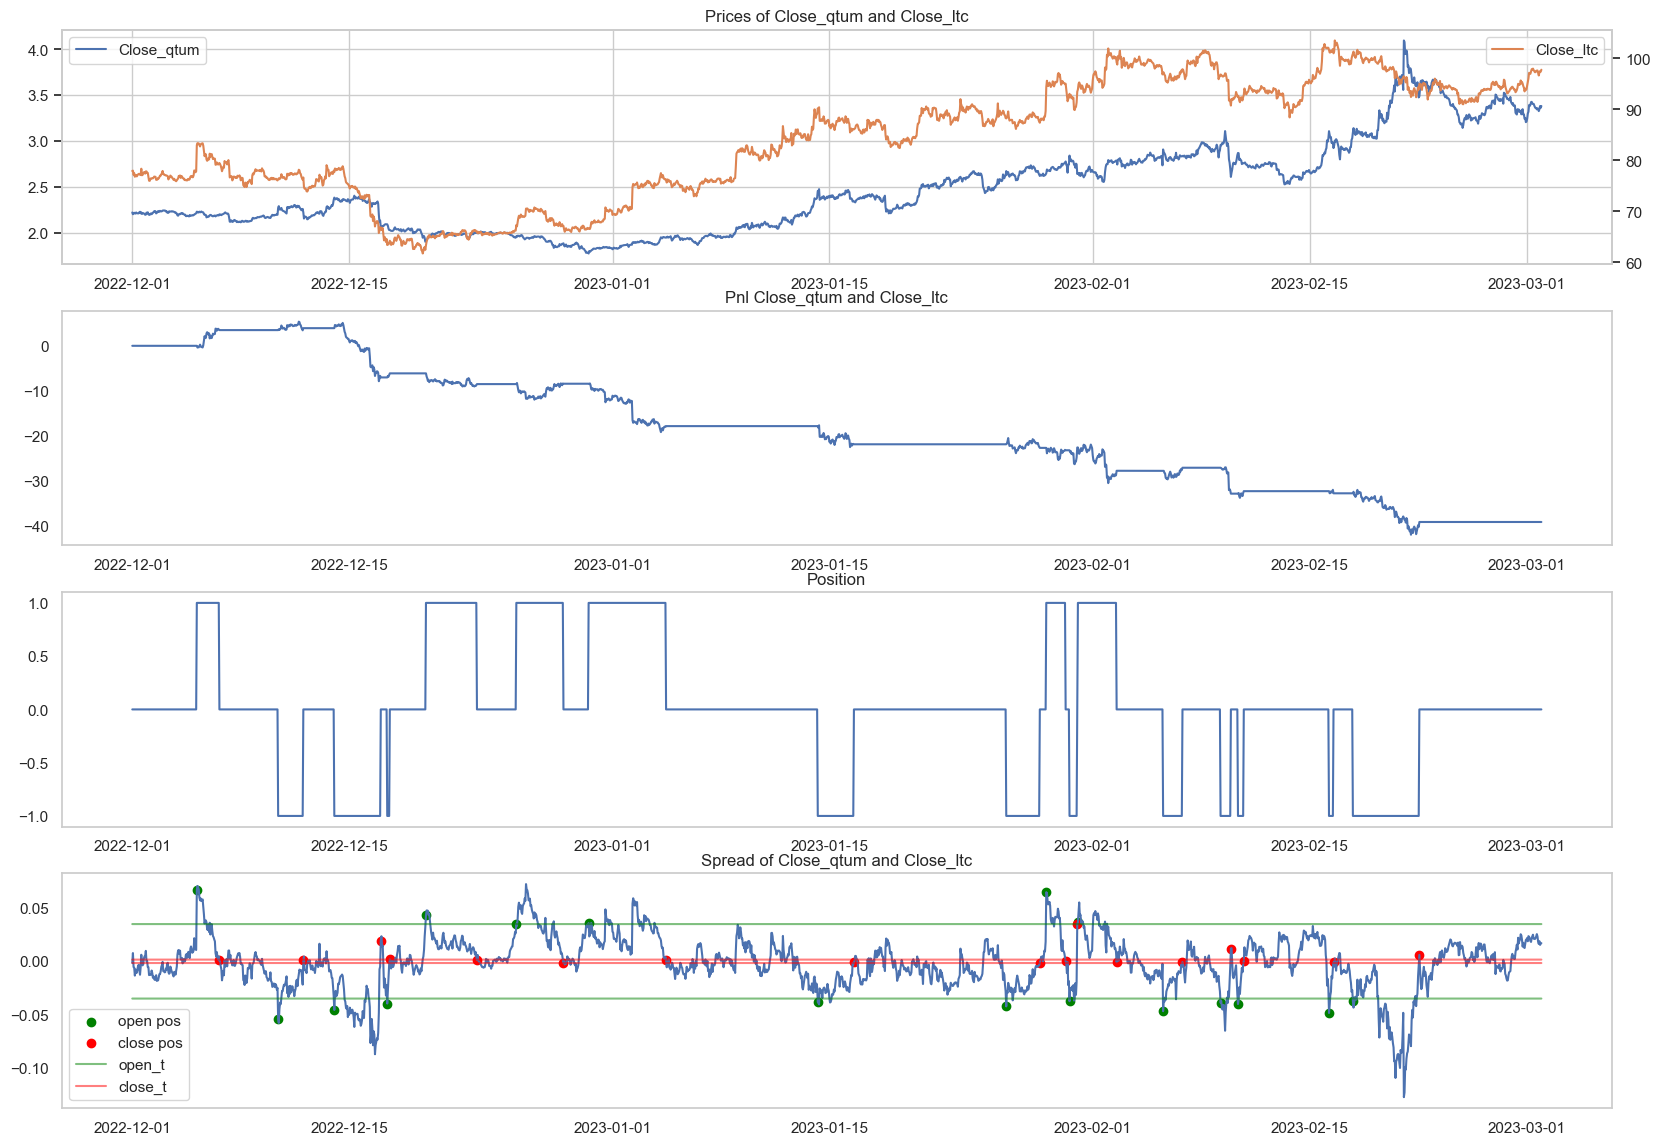

In [101]:
amount = 1
w = 1
open_t = 0.035
close_t = 0.0016

# amount = 1
# w = 1
# open_t = 0.02
# close_t = 0.001

validation['open_t'] = open_t
validation['close_t'] = close_t

total_dfs = []
for pair in pairs:
    total_df = run_pair_strategy(validation, [pair[1], pair[0]], f'spread_kalman', amount, w, pair_strategy, verbose=True, viz=True)
    total_dfs.append(total_df)

Test

final_pnl ('Close_ltc', 'Close_qtum'): -34.222
pnl_per_day: -0.1282
trades: 34
max_dd: 50.588
sharpe_ratio: -1.3959
pnl_to_max_dd: -0.6765


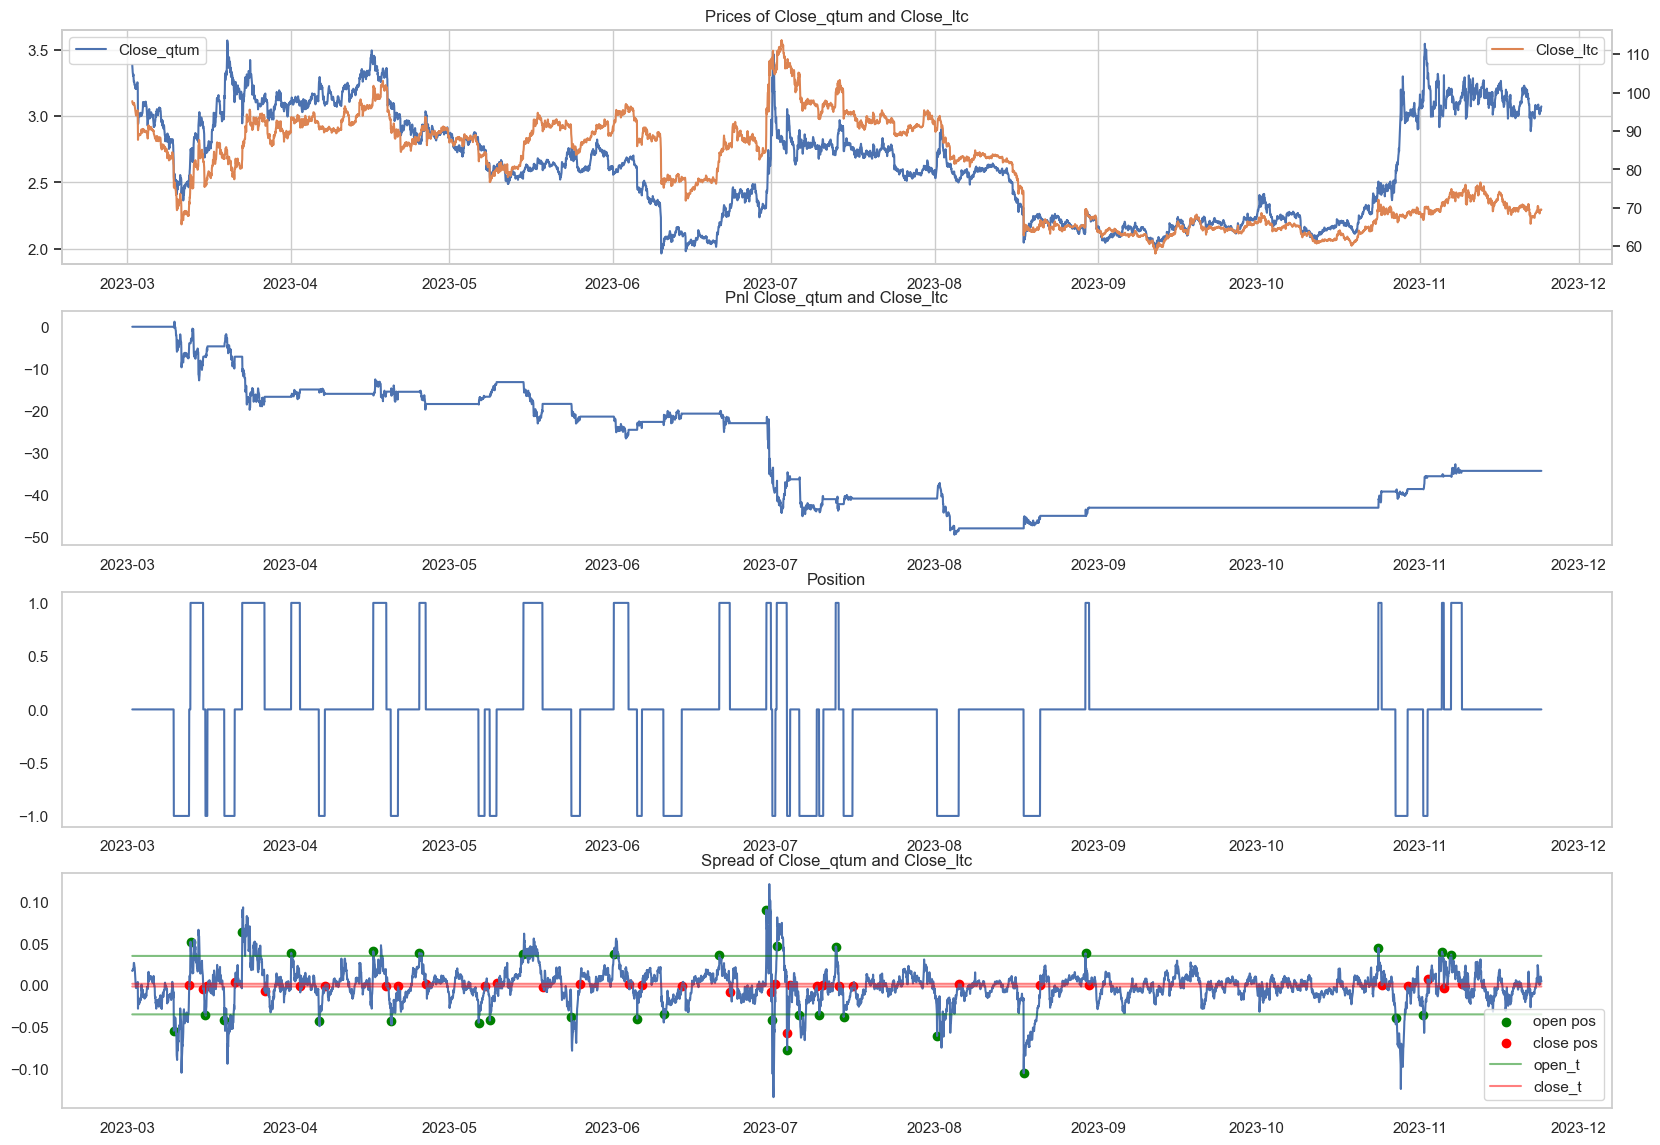

In [102]:
amount = 1
w = 1
open_t = 0.035
close_t = 0.0016

# amount = 1
# w = 1
# open_t = 0.02
# close_t = 0.001

test['open_t'] = open_t
test['close_t'] = close_t

total_dfs = []
for pair in pairs:
    total_df = run_pair_strategy(test, [pair[1], pair[0]], f'spread_kalman', amount, w, pair_strategy, verbose=True, viz=True)
    total_dfs.append(total_df)

### Improvements

As boundaries, take the average value of the spread on the moving window + some constant.

We get the following:

$threshold_{open}(t) = spread(t, t-w) + k_{open}$

$threshold_{close}(t) = spread(t, t-w) + k_{close}$

$k_{close} < k_{open}$

Where:

$threshold_{open}(t)$ - limit for opening a position

$threshold_{close}(t)$ - limit for closing a position

$spread(t, t-w)$ - average spread value in the period from moment $t - w$ to moment $t$

$w$ - sliding window size

final_pnl ('Close_ltc', 'Close_qtum'): -26.421
pnl_per_day: -0.2936
trades: 15
max_dd: 26.822
sharpe_ratio: -3.736
pnl_to_max_dd: -0.985


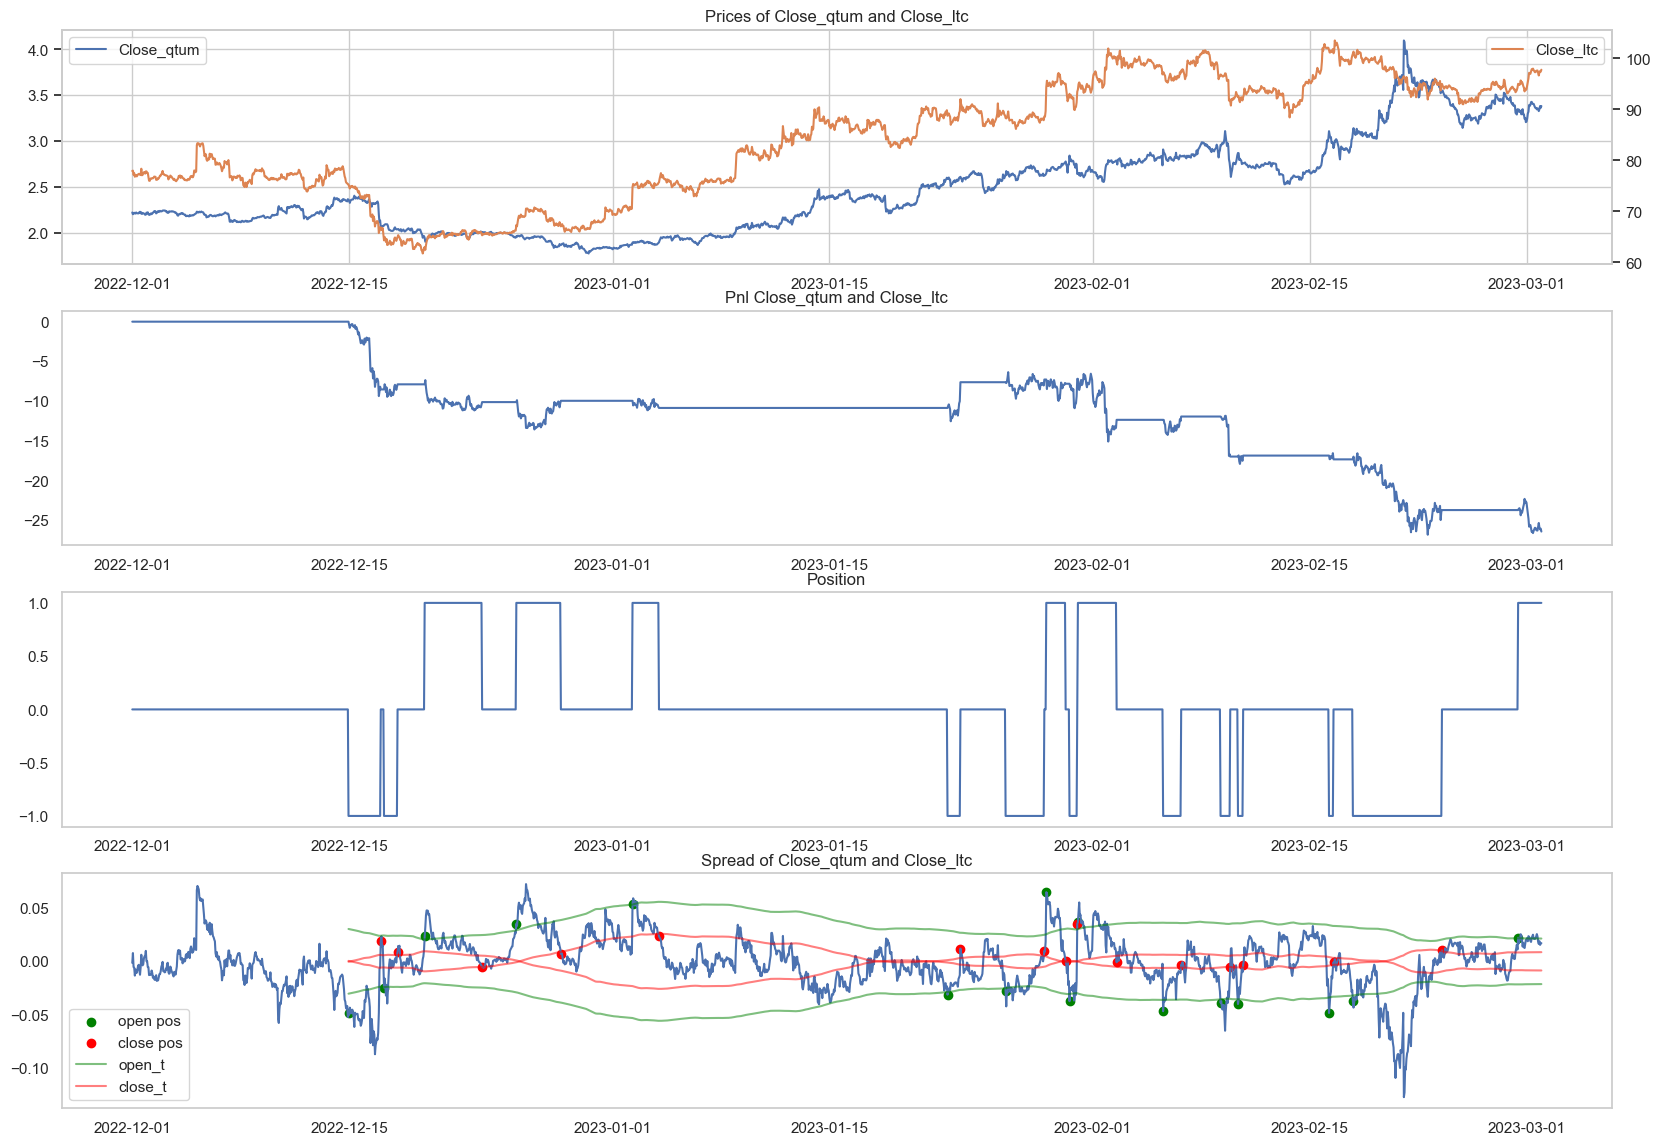

In [106]:
amount = 1
w = 1

window = 24 * 14
k_open = 0.035
k_close = 0.01

# amount = 1
# w = 1

# window = 24 * 14
# k_open = 0.039
# k_close = 0

for pair in zip(pairs):
    rolling_spread = validation[f'spread_kalman'].rolling(window=window)

    open_t = rolling_spread.mean() + k_open
    close_t = rolling_spread.mean() + k_close

    validation[f'open_t'] = open_t
    validation[f'close_t'] = close_t

for pair in pairs:
    total_df = run_pair_strategy(validation, [pair[1], pair[0]], f'spread_kalman', amount, w, pair_strategy, 
                                [f'open_t', f'close_t'], verbose=True, viz=True)

Test

final_pnl ('Close_ltc', 'Close_qtum'): -35.227
pnl_per_day: -0.1319
trades: 32
max_dd: 55.447
sharpe_ratio: -1.392
pnl_to_max_dd: -0.6353


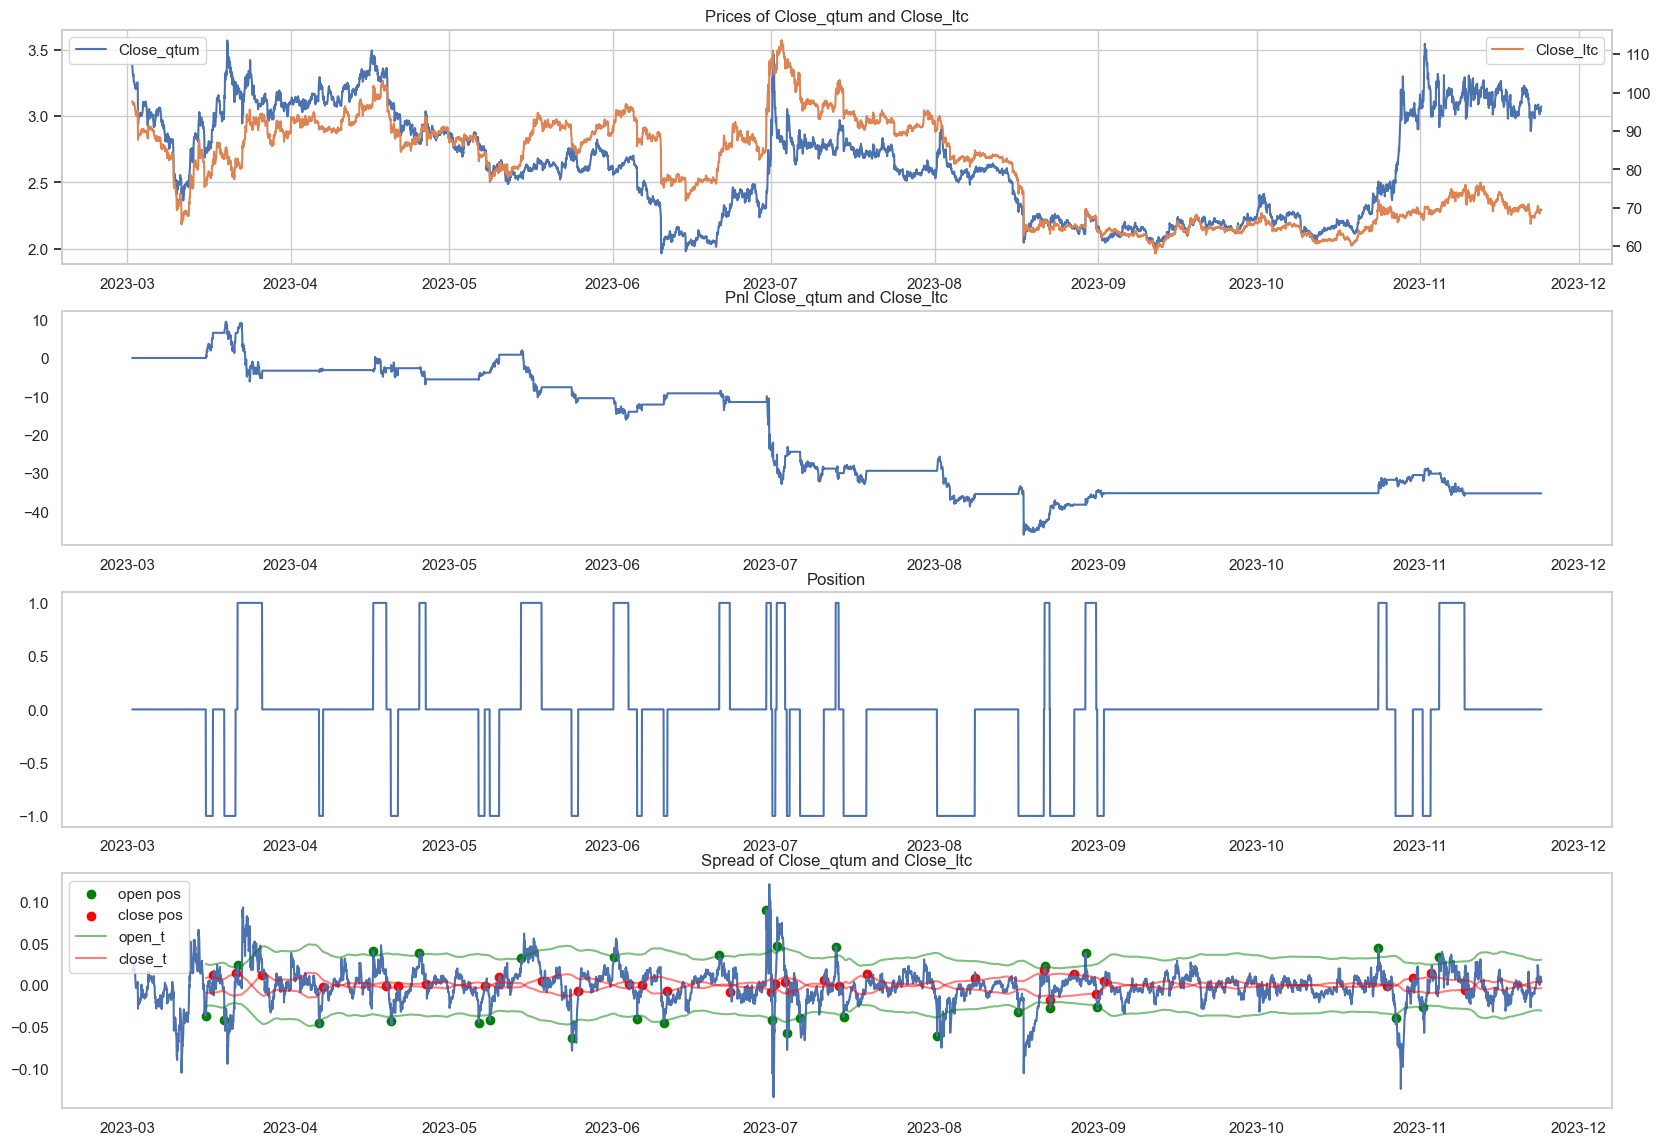

In [107]:
amount = 1
w = 1

window = 24 * 14
k_open = 0.035
k_close = 0.001

# amount = 1
# w = 1

# window = 24 * 14
# k_open = 0.039
# k_close = 0

for pair in zip(pairs):
    rolling_spread = test[f'spread_kalman'].rolling(window=window)

    open_t = rolling_spread.mean() + k_open
    close_t = rolling_spread.mean() + k_close

    test[f'open_t'] = open_t
    test[f'close_t'] = close_t

for pair in pairs:
    total_df = run_pair_strategy(test, [pair[1], pair[0]], f'spread_kalman', amount, w, pair_strategy, 
                                [f'open_t', f'close_t'], verbose=True, viz=True)

### Consider another trading rule

In [108]:
def pair_strategy_2(curr_trade: list, pos: float, index: int, spread: pd.Series, data: pd.DataFrame, t_cols: list) -> tuple:
    if spread >= data[t_cols[0]][index] and pos == 0:  # open long
        pos = amount
        desicion = 'open'
    elif spread <= data[t_cols[1]][index] and pos == 0:  # open short
        pos = -amount
        desicion = 'open'
    elif (spread <= data[t_cols[2]][index] and pos > 0) or (spread >= -data[t_cols[2]][index] and pos < 0):  # close
        pos = 0
        desicion = 'close'
    else:
        desicion = 'hold'
    return desicion, pos

final_pnl ('Close_ltc', 'Close_qtum'): -27.552
pnl_per_day: -0.3061
trades: 13
max_dd: 28.27
sharpe_ratio: -3.8151
pnl_to_max_dd: -0.9746


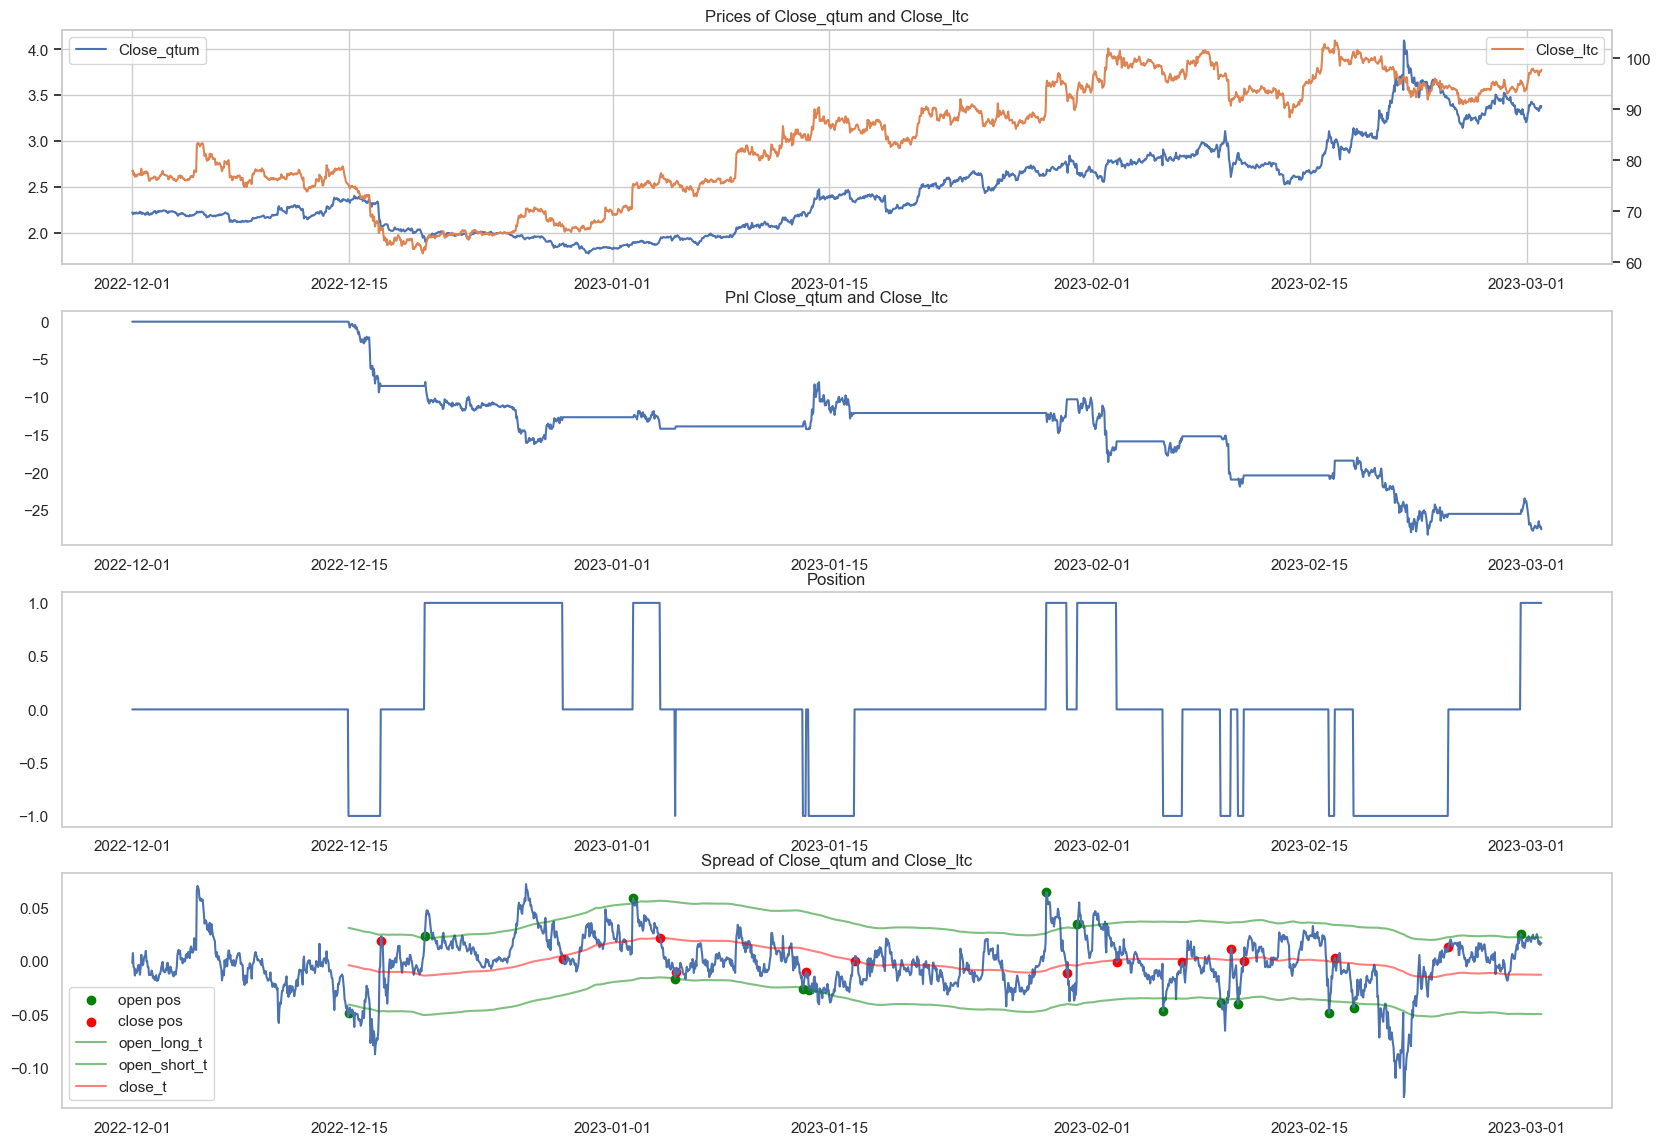

In [109]:
# amount = 1
# w = 1

# window = 24 * 7
# k_open = 0.03
# k_close = 0.

amount = 1
w = 1

window = 24 * 14
k_open = 0.036
k_close = 0.001

# amount = 1
# w = 1

# window = 24 * 3
# k_open = 0.011
# k_close = 0

for pair in pairs:
    rolling_spread = validation[f'spread_kalman'].rolling(window=window)

    open_long_t = rolling_spread.mean() + k_open
    open_short_t = rolling_spread.mean() - k_open
    close_t = rolling_spread.mean() + k_close


    validation[f'open_long_t'] = open_long_t
    validation[f'open_short_t'] = open_short_t
    validation[f'close_t'] = close_t

for pair in pairs:
    total_df = run_pair_strategy(validation, [pair[1], pair[0]], f'spread_kalman', amount, w, pair_strategy_2, 
                                [f'open_long_t', f'open_short_t', 
                                f'close_t'], verbose=True, viz=True)

final_pnl ('Close_ltc', 'Close_qtum'): -37.114
pnl_per_day: -0.139
trades: 30
max_dd: 52.489
sharpe_ratio: -1.609
pnl_to_max_dd: -0.7071


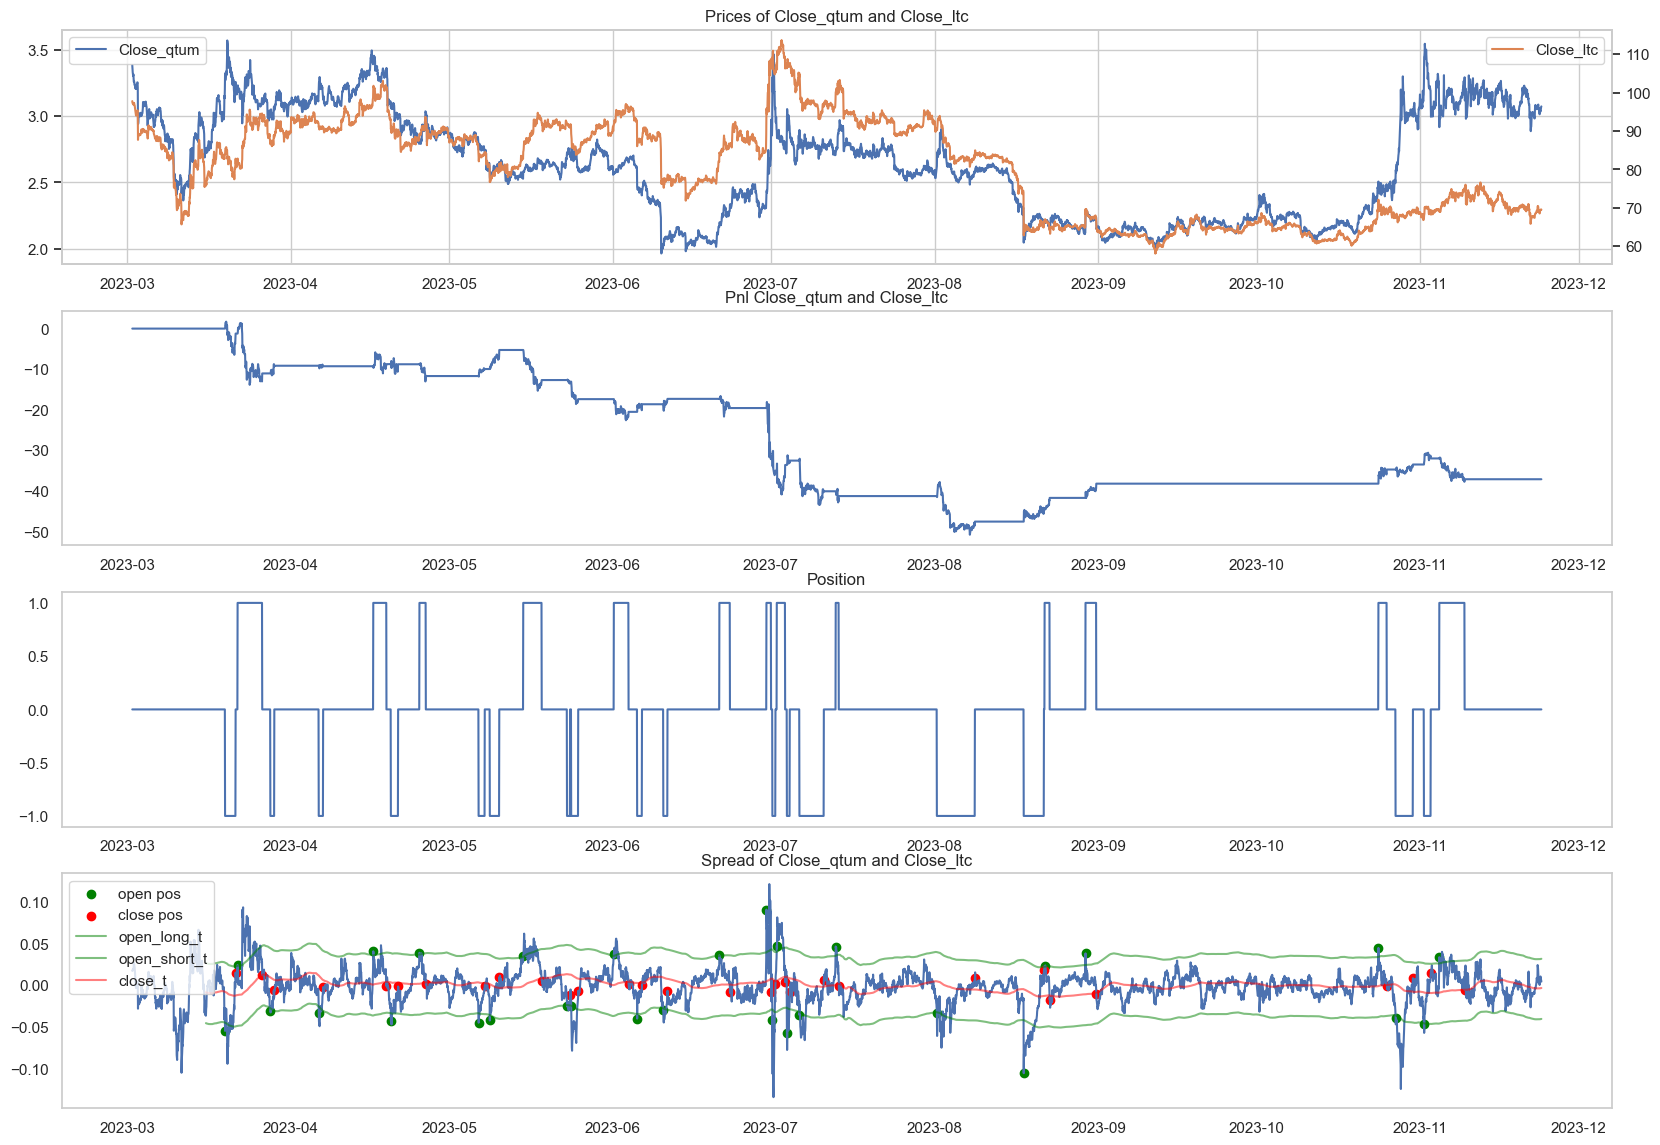

In [110]:
amount = 1
w = 1

window = 24 * 14
k_open = 0.036
k_close = 0.001

# amount = 1
# w = 1

# window = 24 * 3
# k_open = 0.011
# k_close = 0

for pair in pairs:
    rolling_spread = test[f'spread_kalman'].rolling(window=window)

    open_long_t = rolling_spread.mean() + k_open
    open_short_t = rolling_spread.mean() - k_open
    close_t = rolling_spread.mean() + k_close


    test[f'open_long_t'] = open_long_t
    test[f'open_short_t'] = open_short_t
    test[f'close_t'] = close_t

for pair in pairs:
    total_df = run_pair_strategy(test, [pair[1], pair[0]], f'spread_kalman', amount, w, pair_strategy_2, 
                                [f'open_long_t', f'open_short_t', 
                                f'close_t'], verbose=True, viz=True)

### Let's consider another rule

In [111]:
def half_life(spread):
    
    spread_lag = spread.shift(1)
    spread_lag.iloc[0] = spread_lag.iloc[1]
    spread_ret = spread - spread_lag
    spread_ret.iloc[0] = spread_ret.iloc[1]
    spread_lag2 = sm.add_constant(spread_lag)
    model = sm.OLS(spread_ret,spread_lag2)
    res = model.fit()
    halflife = int(round(-np.log(2) / res.params[1],0))
    
    if halflife <= 0:
        halflife = 1
        
    return halflife

In [112]:
from scipy.ndimage import shift

def pair_strategy_modified(curr_trade: list, pos: float, index: int, spread: pd.Series, data: pd.DataFrame, t_cols: list, spred_prev: pd.Series) -> tuple:
    testov = spred_prev
    if spread >= data[t_cols[0]][index] and pos == 0 and testov < data[t_cols[0]][index]:  # open long
        pos = amount
        desicion = 'open'
    elif spread <= -data[t_cols[0]][index] and pos == 0 and testov > -data[t_cols[0]][index]:  # open short
        pos = -amount
        desicion = 'open'
    elif (spread <= data[t_cols[1]][index] and pos > 0) or (spread >= -data[t_cols[1]][index] and pos < 0):  # close
        pos = 0
        desicion = 'close'
    else:
        desicion = 'hold'
    return desicion, pos

New strategy consider spread based on zscore of half-life

In [113]:
def run_pair_strategy(df: pd.DataFrame, price_cols: list, spread_col: str, amount: float, w, strategy: 'function', t_cols: list = None, type: str = None, verbose: bool = True, viz: bool = True) -> tuple:
    if t_cols is None:
        t_cols = ['open_t', 'close_t']
    # spread_values = df[spread_col].to_numpy()
    
    halflife = half_life(df[spread_col].fillna(0))
    # # calculate z-score with window = half life period
    meanSpread = df[spread_col].rolling(window=halflife).mean()
    stdSpread = df[spread_col].rolling(window=halflife).std()
    spread_values = (df[spread_col]-meanSpread)/stdSpread
    spread_values = spread_values.to_numpy()
    
    amounts_vector = np.array([amount, -w * amount])
    prices = df[price_cols].to_numpy()
    prices_to_order = prices * amounts_vector  # цены для покупки / продажи, учитывая сторону сделки

    # Need to delete
    if type == 'zscore':
        spread_values = zscore(df[spread_col])
    elif type == 'zscore_moving_average':
        ratios_mavg5 = df[spread_col].rolling(window=5, center=False).mean()
        ratios_mavg60 = df[spread_col].rolling(window=60, center=False).mean()
        std_60 = df[spread_col].rolling(window=60, center=False).std()
        spread_values = (ratios_mavg5 - ratios_mavg60)/std_60
    
    pnls = []
    open_pnls = []
    trades = []
    all_pos = []
    last_trade = None
    pos = 0
    prev_spread = 0

    for index, spread in enumerate(spread_values):
        curr_trade = prices_to_order[index]
        curr_opnl = 0
        curr_pnl = 0
        
        desicion, new_pos = strategy(curr_trade, pos, index, spread, df, t_cols, prev_spread)
        prev_spread = spread

        # считаем либо close pnl, либо open pnl
        if desicion == 'open':
            last_trade = curr_trade
            pos = new_pos
        elif desicion == 'close':
            curr_pnl = calc_pnl(last_trade, curr_trade, pos)
            last_trade = None
            pos = 0
        else:
            curr_opnl = calc_pnl(last_trade, curr_trade, pos)
        
        open_pnls.append(curr_opnl)
        pnls.append(curr_pnl)
        trades.append(desicion)
        all_pos.append(pos)
        

    pnls = np.array(pnls)
    open_pnls = np.array(open_pnls)
    trades = np.array(trades)
    
    total_df = df[price_cols].copy()
    total_df['pnl'] = pnls
    total_df['open_pnl'] = open_pnls
    total_df['trades'] = trades
    total_df['position'] = all_pos
    total_df['spread'] = df[spread_col]
    total_df['real_pnl'] = np.cumsum(pnls) + open_pnls
    total_df[t_cols] = df[t_cols]
    
    
    if verbose:
        final_pnl = total_df['real_pnl'].iloc[-1]
        pnl_per_day = final_pnl / (total_df.index[-1] - total_df.index[0]).days
        trades = (total_df['trades'] != 'hold').sum() // 2  # считаем одним трейдом пару открытие-закрытие позиции
        sharpe_ratio = calc_sharpe(total_df['real_pnl'])
        max_dd = calc_max_drawdown(total_df['real_pnl'])
        pnl_to_max_dd = final_pnl / max_dd
        summary = {f'final_pnl {pair}': final_pnl, 'pnl_per_day': pnl_per_day, 'trades': trades, 'max_dd': max_dd, 
                   'sharpe_ratio': sharpe_ratio, 'pnl_to_max_dd': pnl_to_max_dd}
        print(*[f'{key}: {round(value, 4)}' for key, value in summary.items()], sep='\n')
    
    if viz:
        plot_results(total_df, price_cols, t_cols)
        
    return total_df

### Testing

Validation

final_pnl ('Close_ltc', 'Close_qtum'): 39.465
pnl_per_day: 0.4385
trades: 161
max_dd: 14.847
sharpe_ratio: 4.2939
pnl_to_max_dd: 2.6581


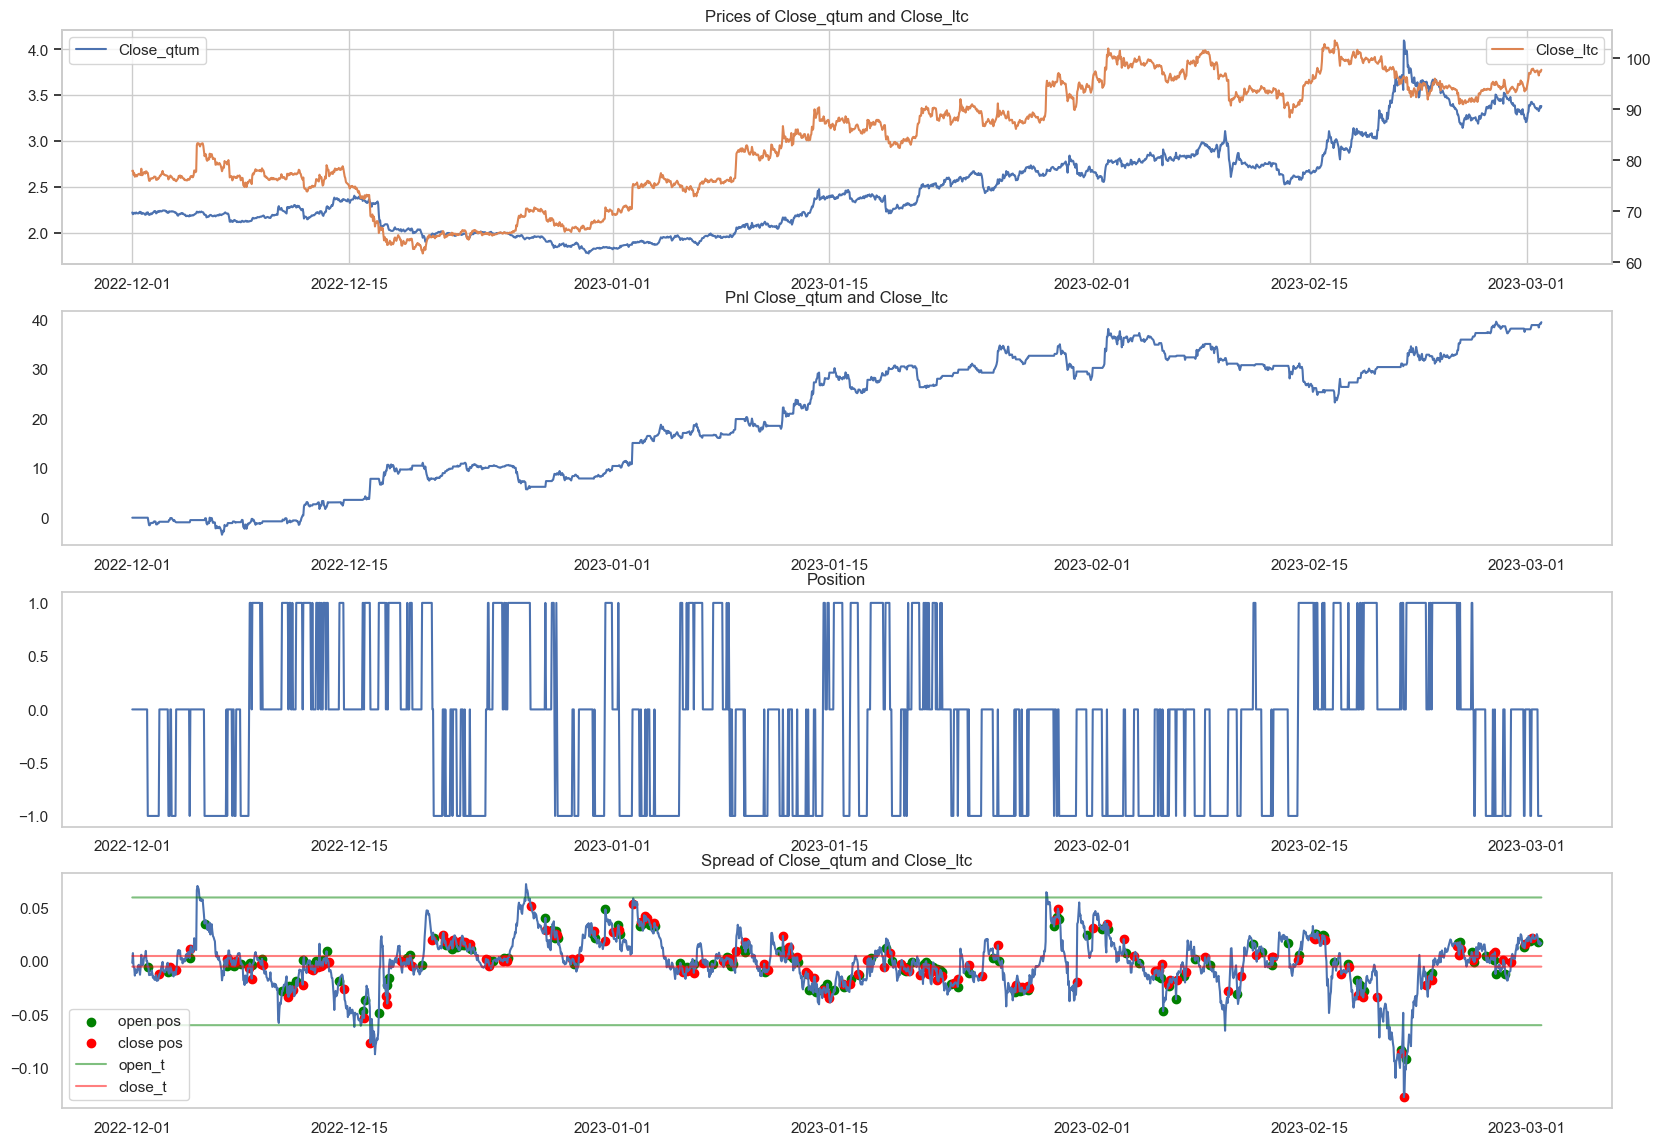

In [114]:
# amount = 1
# w = 1
# open_t = 0.06
# close_t = 0.005

amount = 1
w = 1
open_t = 0.06
close_t = 0.005

# amount = 1
# w = 1
# open_t = 0.08
# close_t = 0


# price_cols = ['Close_qtum', 'Close_neo']

validation['open_t'] = open_t
validation['close_t'] = close_t

total_dfs = []
for pair in pairs:
    total_df = run_pair_strategy(validation, [pair[1], pair[0]], f'spread_kalman', amount, w, pair_strategy_modified, verbose=True, viz=True)
    total_dfs.append(total_df)

Test

final_pnl ('Close_ltc', 'Close_qtum'): 37.656
pnl_per_day: 0.141
trades: 472
max_dd: 25.422
sharpe_ratio: 1.3074
pnl_to_max_dd: 1.4812


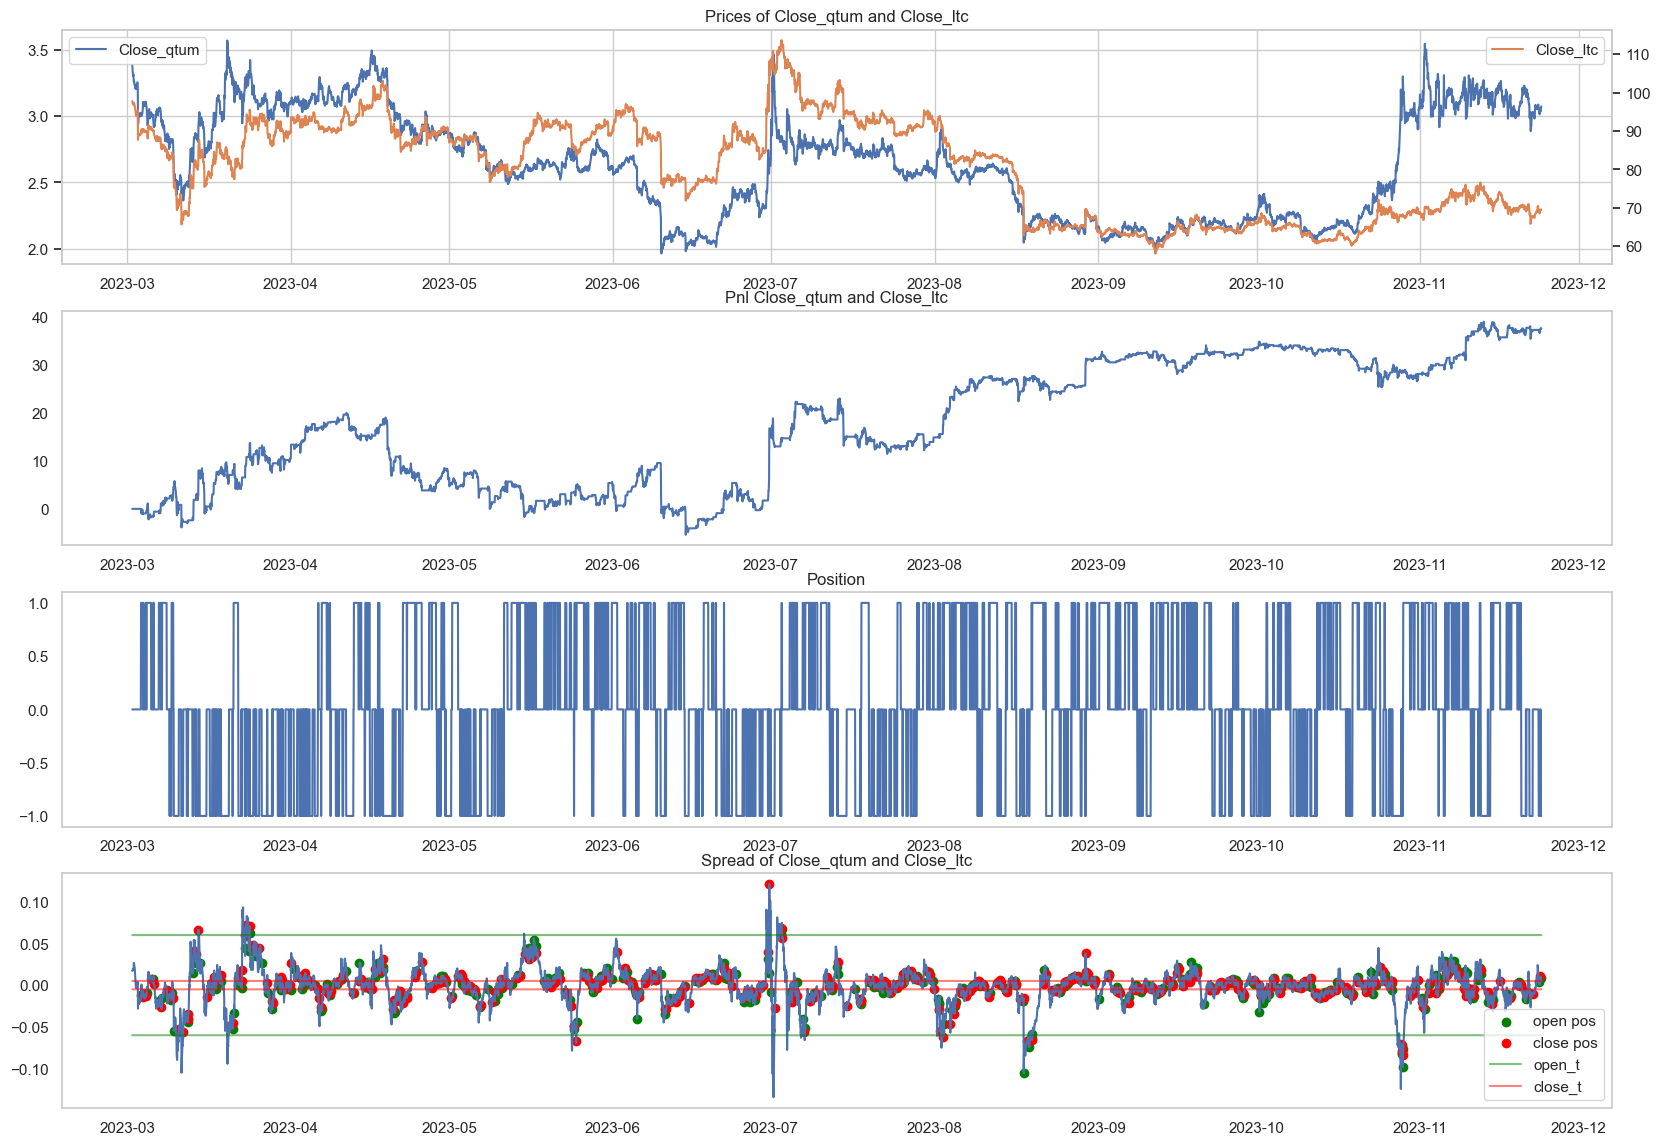

In [115]:
amount = 1
w = 1
open_t = 0.06
close_t = 0.005

# amount = 1
# w = 1
# open_t = 0.08
# close_t = 0

# price_cols = ['Close_qtum', 'Close_neo']

test['open_t'] = open_t
test['close_t'] = close_t

total_dfs = []
for pair in pairs:
    total_df = run_pair_strategy(test, [pair[1], pair[0]], f'spread_kalman', amount, w, pair_strategy_modified, verbose=True, viz=True)
    total_dfs.append(total_df)

Validation

final_pnl ('Close_ltc', 'Close_qtum'): 5.977
pnl_per_day: 0.0664
trades: 145
max_dd: 18.884
sharpe_ratio: 0.6932
pnl_to_max_dd: 0.3165


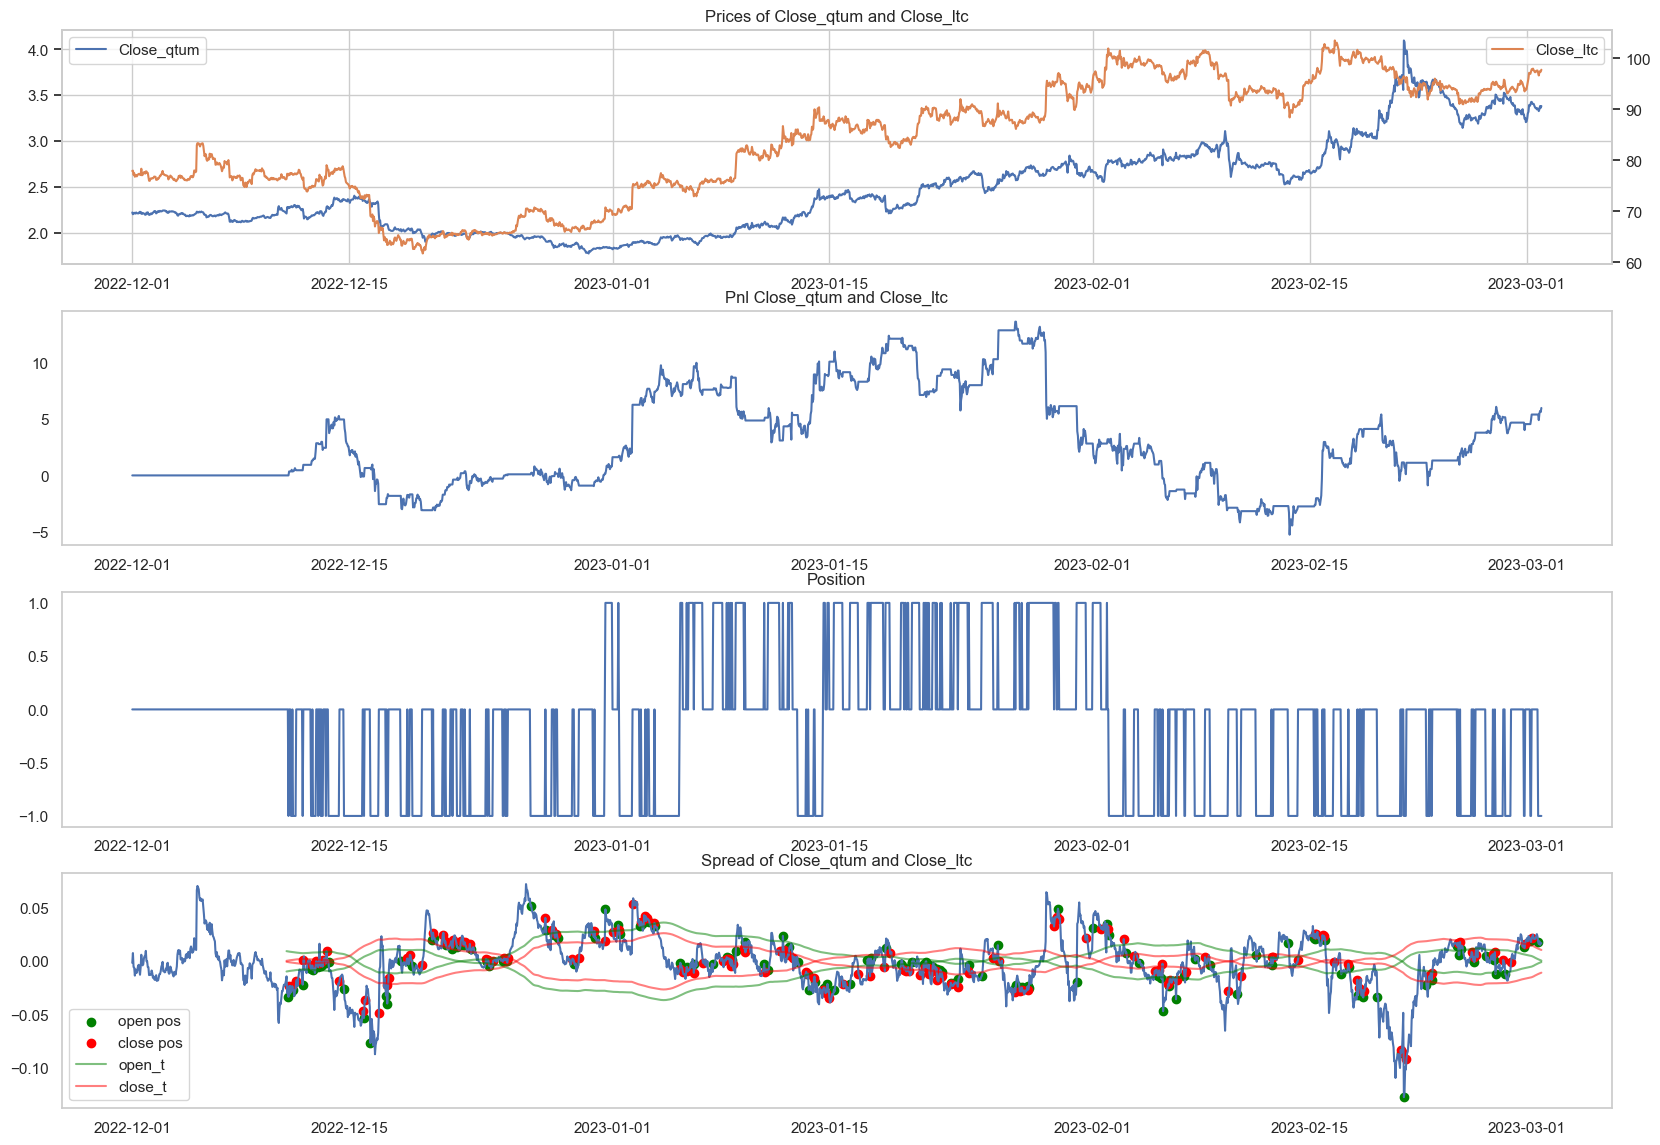

In [116]:
amount = 1
weight = 1

window = 24 * 10
k_open = 0.01
k_close = 0

# amount = 1
# weight = 1

# window = 24 * 14
# k_open = 0.02
# k_close = 0.02

for pair in pairs:
    rolling_spread = validation[f'spread_kalman'].rolling(window=window)

    open_t = rolling_spread.mean() + k_open
    close_t = rolling_spread.mean() + k_close

    validation[f'open_t'] = open_t
    validation[f'close_t'] = close_t

for pair in pairs:
    total_df = run_pair_strategy(validation, [pair[1], pair[0]], f'spread_kalman', amount, w, pair_strategy_modified, 
                                [f'open_t', f'close_t'], verbose=True, viz=True)

final_pnl ('Close_ltc', 'Close_qtum'): 72.696
pnl_per_day: 0.2723
trades: 447
max_dd: 15.09
sharpe_ratio: 2.7136
pnl_to_max_dd: 4.8175


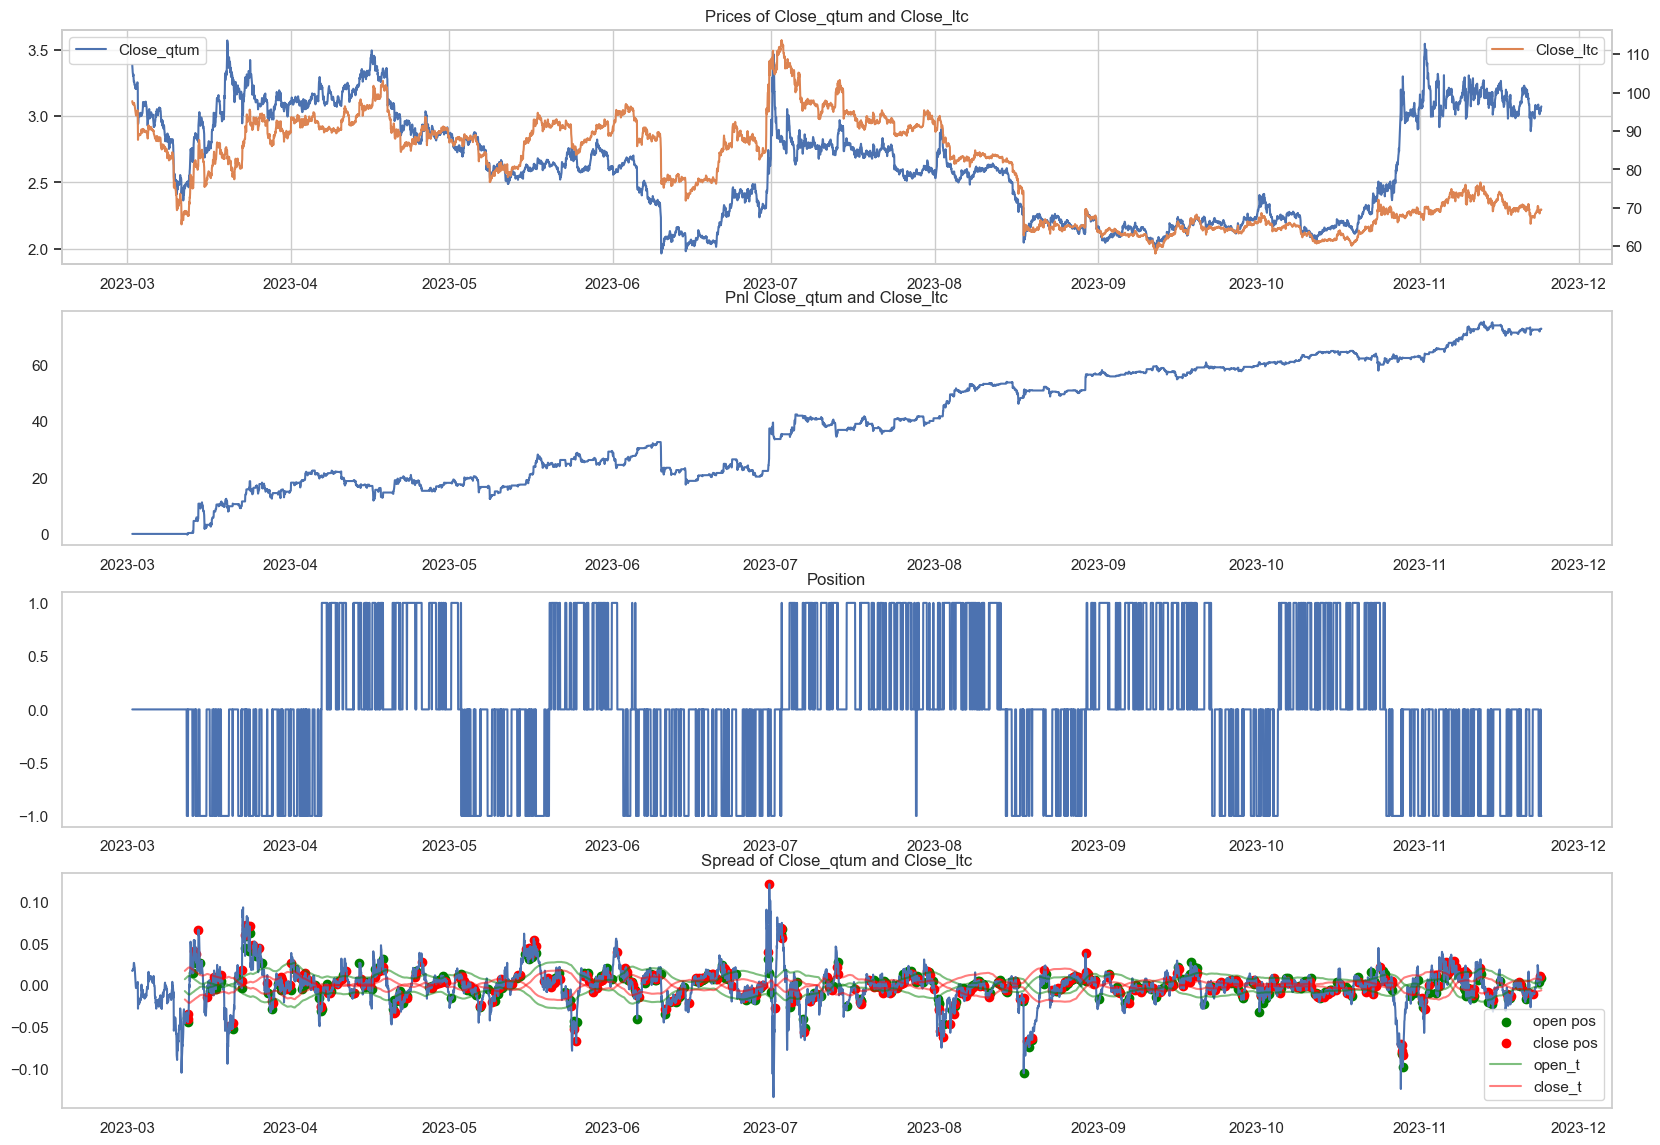

In [117]:
amount = 1
weight = 1

window = 24 * 10
k_open = 0.01
k_close = 0

# amount = 1
# weight = 1

# window = 24 * 14
# k_open = 0.02
# k_close = 0.02

for pair in pairs:
    rolling_spread = test[f'spread_kalman'].rolling(window=window)

    open_t = rolling_spread.mean() + k_open
    close_t = rolling_spread.mean() + k_close

    test[f'open_t'] = open_t
    test[f'close_t'] = close_t

for pair in pairs:
    total_df = run_pair_strategy(test, [pair[1], pair[0]], f'spread_kalman', amount, w, pair_strategy_modified, 
                                [f'open_t', f'close_t'], verbose=True, viz=True)

In [118]:
def pair_strategy_2_modified(curr_trade: list, pos: float, index: int, spread: pd.Series, data: pd.DataFrame, t_cols: list, spred_prev: pd.Series) -> tuple:
    testov = spred_prev
    if spread >= data[t_cols[0]][index] and pos == 0 and testov < data[t_cols[0]][index]:  # open long
        pos = amount
        desicion = 'open'
    elif spread <= data[t_cols[1]][index] and pos == 0 and testov > -data[t_cols[0]][index]:  # open short
        pos = -amount
        desicion = 'open'
    elif (spread <= data[t_cols[2]][index] and pos > 0) or (spread >= -data[t_cols[2]][index] and pos < 0):  # close
        pos = 0
        desicion = 'close'
    else:
        desicion = 'hold'
    return desicion, pos
    

Validation

final_pnl ('Close_ltc', 'Close_qtum'): 5.48
pnl_per_day: 0.0609
trades: 144
max_dd: 18.884
sharpe_ratio: 0.6358
pnl_to_max_dd: 0.2902


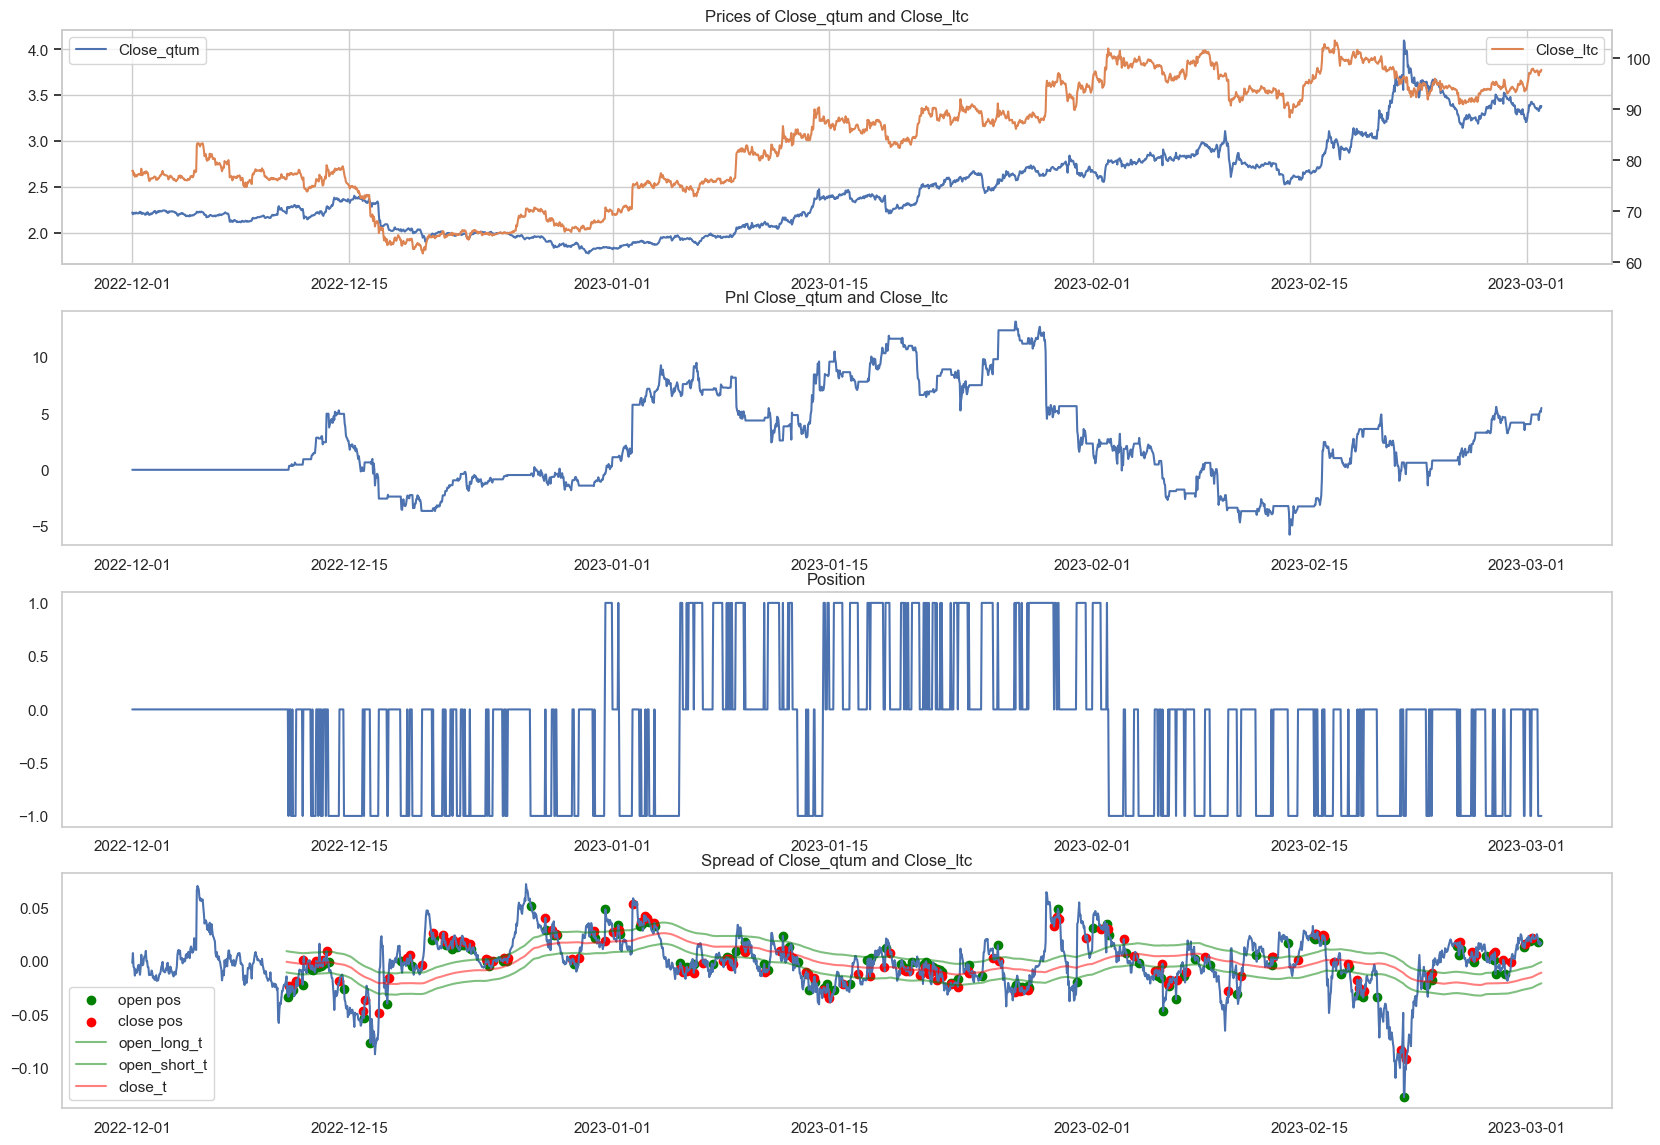

In [119]:
amount = 1
weight = 1

window = 24 * 10
k_open = 0.01
k_close = 0

# amount = 1
# weight = 1

# window = 24 * 3
# k_open = 0.21
# k_close = 0.01

for pair in pairs:
    rolling_spread = validation[f'spread_kalman'].rolling(window=window)

    open_long_t = rolling_spread.mean() + k_open
    open_short_t = rolling_spread.mean() - k_open
    close_t = rolling_spread.mean() + k_close


    validation[f'open_long_t'] = open_long_t
    validation[f'open_short_t'] = open_short_t
    validation[f'close_t'] = close_t

for pair in pairs:
    total_df = run_pair_strategy(validation, [pair[1], pair[0]], f'spread_kalman', amount, w, pair_strategy_2_modified, 
                                [f'open_long_t', f'open_short_t', 
                                f'close_t'], verbose=True, viz=True)

Test

final_pnl ('Close_ltc', 'Close_qtum'): 36.005
pnl_per_day: 0.1349
trades: 446
max_dd: 33.945
sharpe_ratio: 1.3498
pnl_to_max_dd: 1.0607


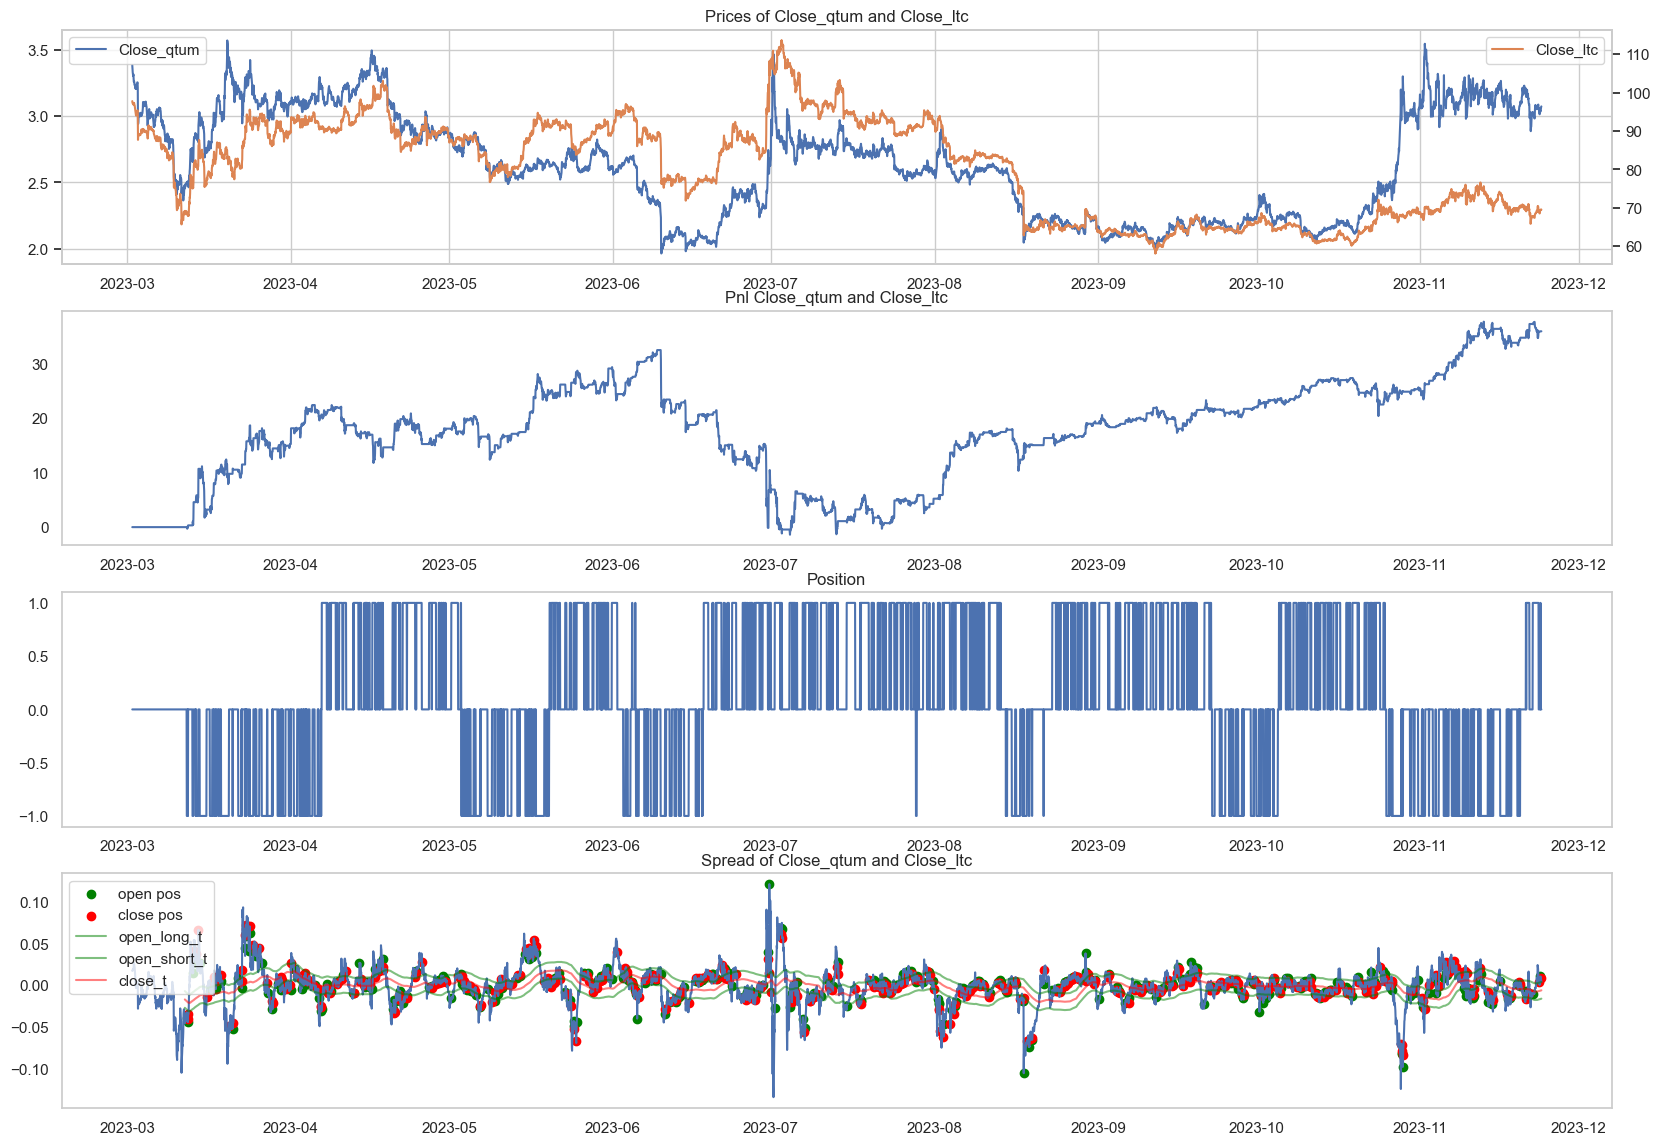

In [120]:
amount = 1
weight = 1

window = 24 * 10
k_open = 0.01
k_close = 0

# amount = 1
# weight = 1

# window = 24 * 3
# k_open = 0.21
# k_close = 0.01

for pair in pairs:
    rolling_spread = test[f'spread_kalman'].rolling(window=window)

    open_long_t = rolling_spread.mean() + k_open
    open_short_t = rolling_spread.mean() - k_open
    close_t = rolling_spread.mean() + k_close


    test[f'open_long_t'] = open_long_t
    test[f'open_short_t'] = open_short_t
    test[f'close_t'] = close_t

for pair in pairs:
    total_df = run_pair_strategy(test, [pair[1], pair[0]], f'spread_kalman', amount, w, pair_strategy_2_modified, 
                                [f'open_long_t', f'open_short_t', 
                                f'close_t'], verbose=True, viz=True)

Now consider previous strategy but without half-life

In [121]:
def run_pair_strategy(df: pd.DataFrame, price_cols: list, spread_col: str, amount: float, w, strategy: 'function', t_cols: list = None, type: str = None, verbose: bool = True, viz: bool = True) -> tuple:
    if t_cols is None:
        t_cols = ['open_t', 'close_t']
    spread_values = df[spread_col].to_numpy()
    amounts_vector = np.array([amount, -w * amount])
    prices = df[price_cols].to_numpy()
    prices_to_order = prices * amounts_vector  # цены для покупки / продажи, учитывая сторону сделки

    # Need to delete
    if type == 'zscore':
        spread_values = zscore(df[spread_col])
    elif type == 'zscore_moving_average':
        ratios_mavg5 = df[spread_col].rolling(window=5, center=False).mean()
        ratios_mavg60 = df[spread_col].rolling(window=60, center=False).mean()
        std_60 = df[spread_col].rolling(window=60, center=False).std()
        spread_values = (ratios_mavg5 - ratios_mavg60)/std_60
    
    pnls = []
    open_pnls = []
    trades = []
    all_pos = []
    last_trade = None
    pos = 0
    prev_spread = 0

    for index, spread in enumerate(spread_values):
        curr_trade = prices_to_order[index]
        curr_opnl = 0
        curr_pnl = 0
        
        desicion, new_pos = strategy(curr_trade, pos, index, spread, df, t_cols, prev_spread)
        prev_spread = spread

        # считаем либо close pnl, либо open pnl
        if desicion == 'open':
            last_trade = curr_trade
            pos = new_pos
        elif desicion == 'close':
            curr_pnl = calc_pnl(last_trade, curr_trade, pos)
            last_trade = None
            pos = 0
        else:
            curr_opnl = calc_pnl(last_trade, curr_trade, pos)
        
        open_pnls.append(curr_opnl)
        pnls.append(curr_pnl)
        trades.append(desicion)
        all_pos.append(pos)
        

    pnls = np.array(pnls)
    open_pnls = np.array(open_pnls)
    trades = np.array(trades)
    
    total_df = df[price_cols].copy()
    total_df['pnl'] = pnls
    total_df['open_pnl'] = open_pnls
    total_df['trades'] = trades
    total_df['position'] = all_pos
    total_df['spread'] = df[spread_col]
    total_df['real_pnl'] = np.cumsum(pnls) + open_pnls
    total_df[t_cols] = df[t_cols]
    
    
    if verbose:
        final_pnl = total_df['real_pnl'].iloc[-1]
        pnl_per_day = final_pnl / (total_df.index[-1] - total_df.index[0]).days
        trades = (total_df['trades'] != 'hold').sum() // 2  # считаем одним трейдом пару открытие-закрытие позиции
        sharpe_ratio = calc_sharpe(total_df['real_pnl'])
        max_dd = calc_max_drawdown(total_df['real_pnl'])
        pnl_to_max_dd = final_pnl / max_dd
        summary = {f'final_pnl {pair}': final_pnl, 'pnl_per_day': pnl_per_day, 'trades': trades, 'max_dd': max_dd, 
                   'sharpe_ratio': sharpe_ratio, 'pnl_to_max_dd': pnl_to_max_dd}
        print(*[f'{key}: {round(value, 4)}' for key, value in summary.items()], sep='\n')
    
    if viz:
        plot_results(total_df, price_cols, t_cols)
        
    return total_df

Validation

final_pnl ('Close_ltc', 'Close_qtum'): -33.549
pnl_per_day: -0.3728
trades: 15
max_dd: 41.719
sharpe_ratio: -4.6685
pnl_to_max_dd: -0.8042


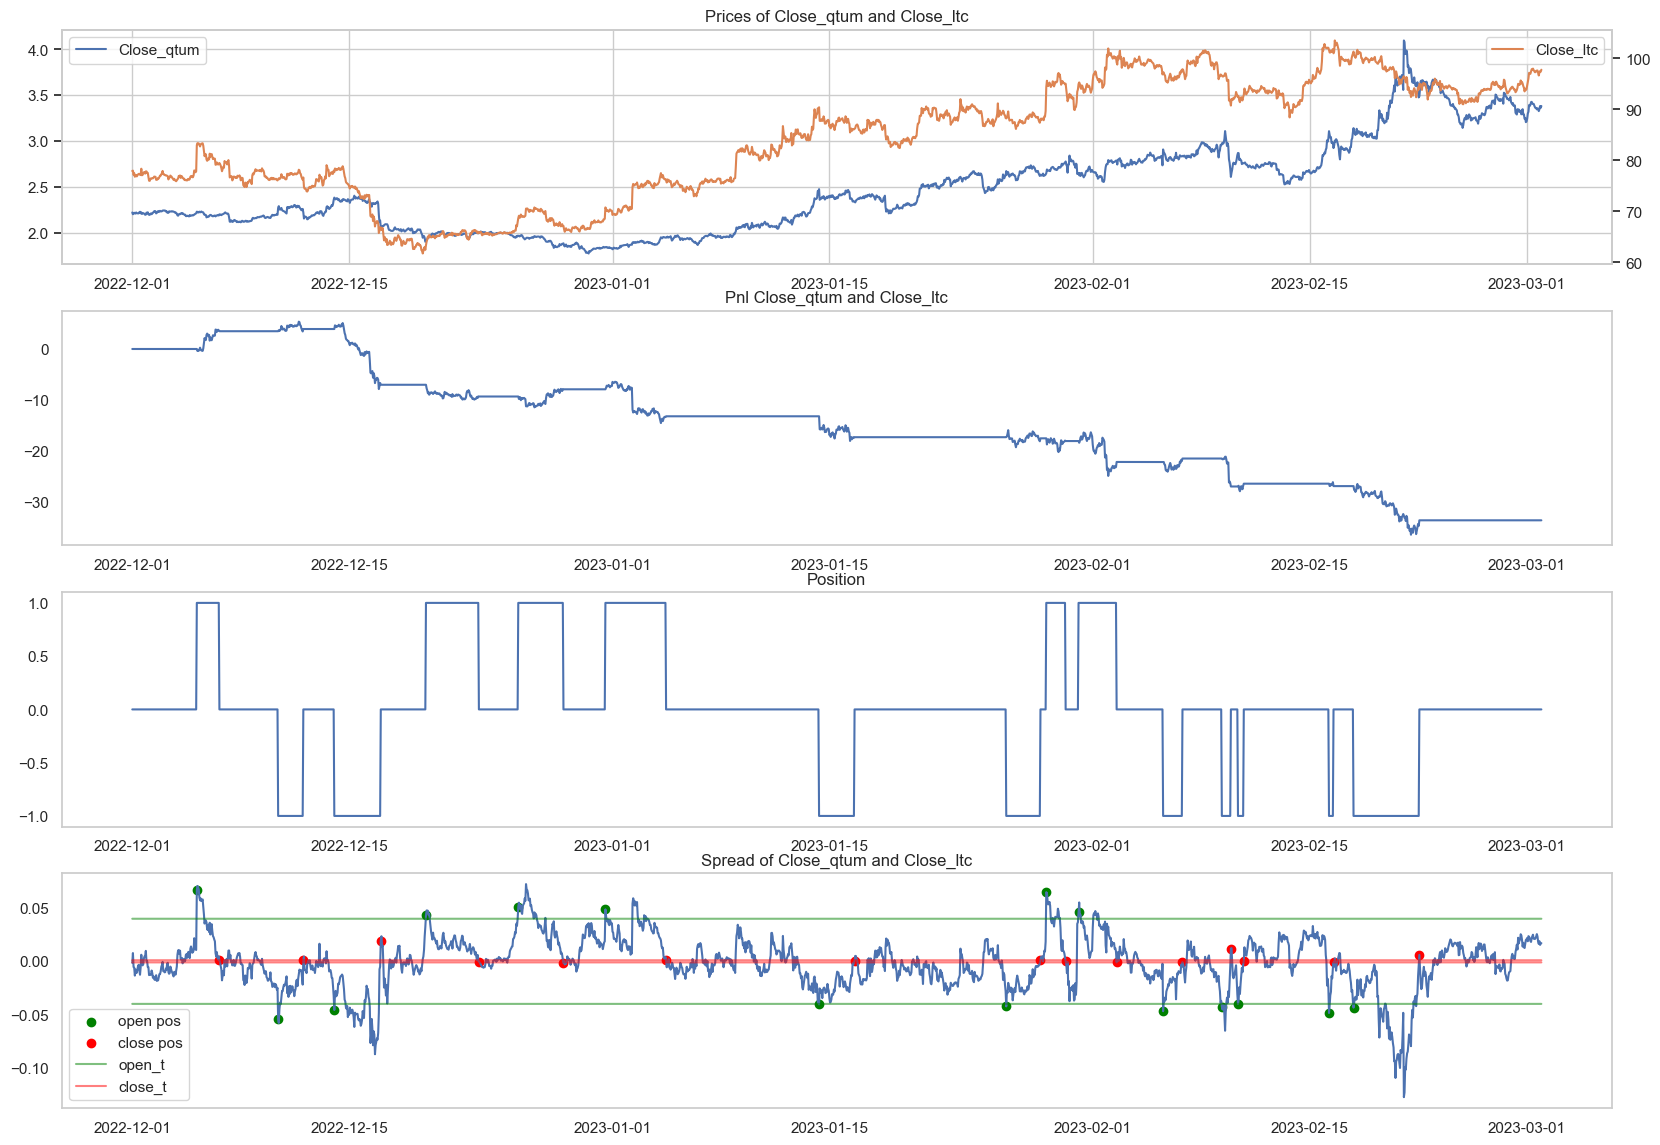

In [122]:
amount = 1
w = 1
open_t = 0.04
close_t = 0.001

# amount = 1
# w = 1
# open_t = 0.021
# close_t = 0.0011

validation['open_t'] = open_t
validation['close_t'] = close_t

total_dfs = []
for pair in pairs:
    total_df = run_pair_strategy(validation, [pair[1], pair[0]], f'spread_kalman', amount, w, pair_strategy_modified, verbose=True, viz=True)
    total_dfs.append(total_df)

Test

final_pnl ('Close_ltc', 'Close_qtum'): -38.051
pnl_per_day: -0.1425
trades: 25
max_dd: 51.222
sharpe_ratio: -1.5956
pnl_to_max_dd: -0.7429


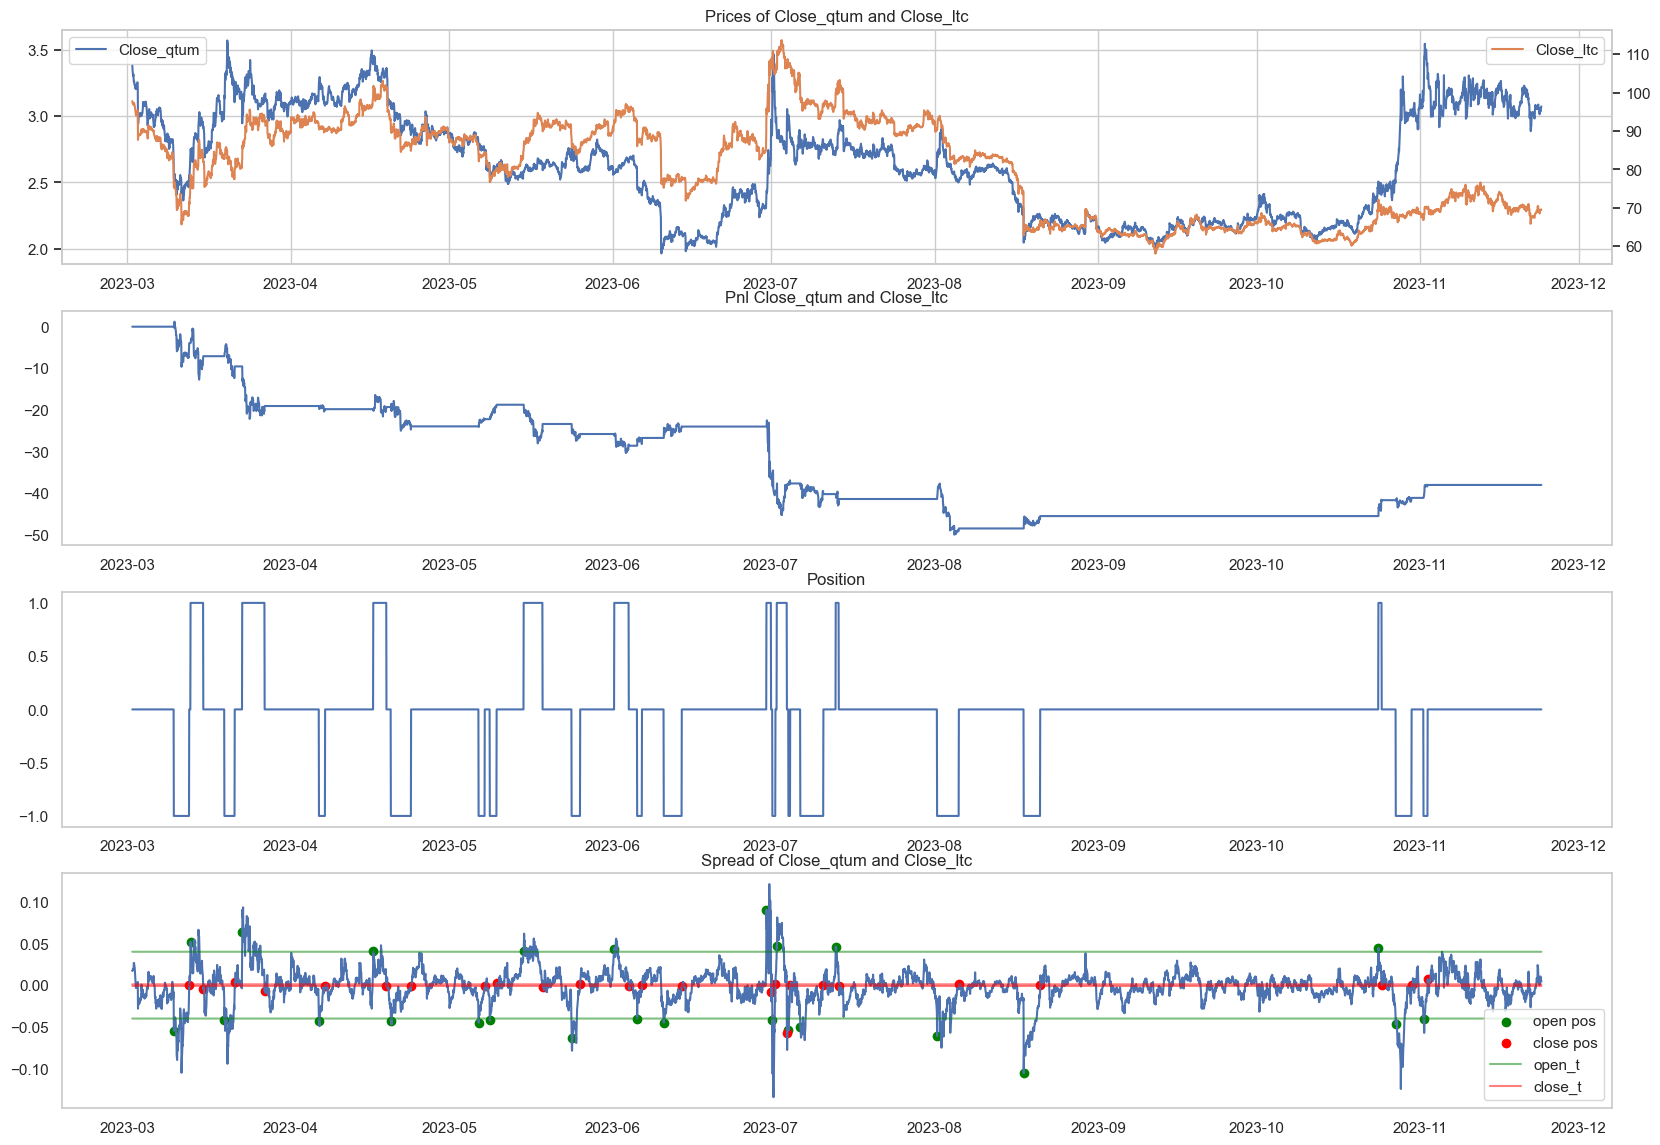

In [123]:
amount = 1
w = 1
open_t = 0.04
close_t = 0.001

# amount = 1
# w = 1
# open_t = 0.021
# close_t = 0.0011

test['open_t'] = open_t
test['close_t'] = close_t

total_dfs = []
for pair in pairs:
    total_df = run_pair_strategy(test, [pair[1], pair[0]], f'spread_kalman', amount, w, pair_strategy_modified, verbose=True, viz=True)
    total_dfs.append(total_df)

Validation

final_pnl ('Close_ltc', 'Close_qtum'): -28.12
pnl_per_day: -0.3124
trades: 13
max_dd: 33.201
sharpe_ratio: -3.8748
pnl_to_max_dd: -0.847


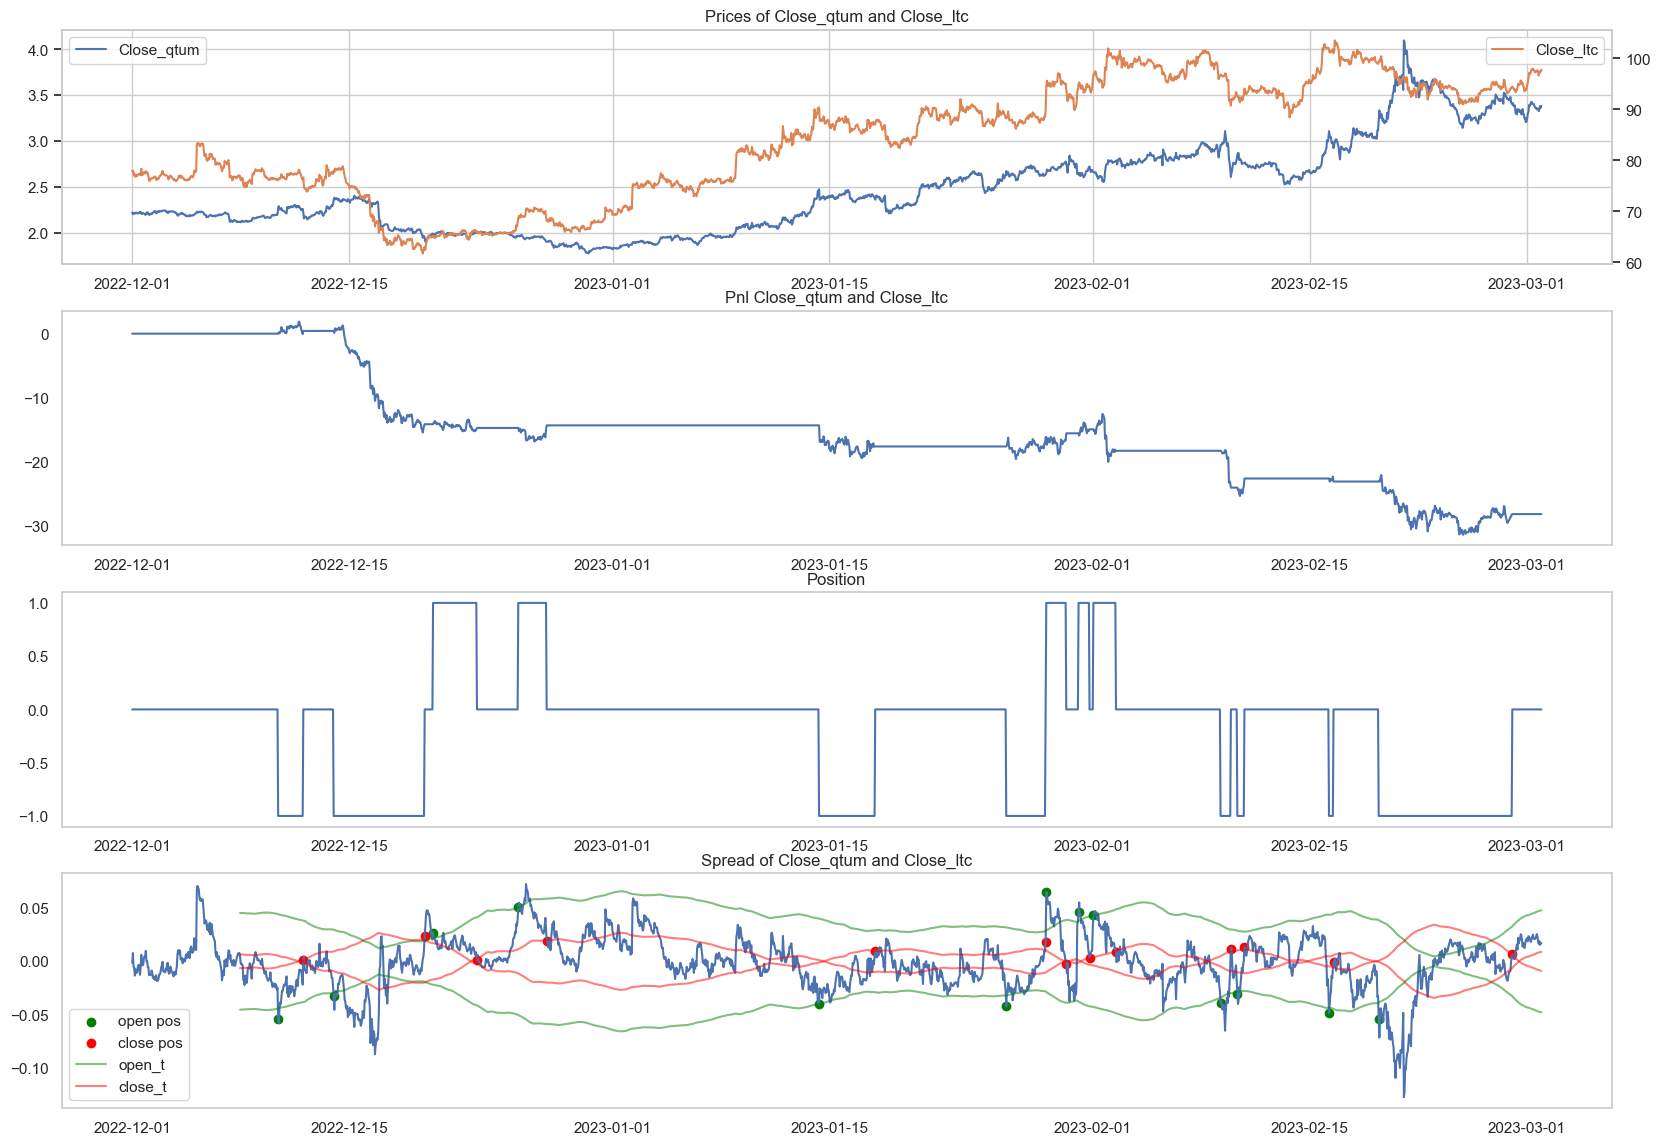

In [124]:
amount = 1
weight = 1

window = 24 * 7
k_open = 0.04
k_close = 0.001

# amount = 1
# weight = 1

# window = 24 * 7
# k_open = 0.03
# k_close = 0

for pair in pairs:
    rolling_spread = validation[f'spread_kalman'].rolling(window=window)

    open_t = rolling_spread.mean() + k_open
    close_t = rolling_spread.mean() + k_close

    validation[f'open_t'] = open_t
    validation[f'close_t'] = close_t

for pair in pairs:
    total_df = run_pair_strategy(validation, [pair[1], pair[0]], f'spread_kalman', amount, w, pair_strategy_modified, 
                                [f'open_t', f'close_t'], verbose=True, viz=True)

Test

final_pnl ('Close_ltc', 'Close_qtum'): -19.616
pnl_per_day: -0.0735
trades: 29
max_dd: 37.27
sharpe_ratio: -0.799
pnl_to_max_dd: -0.5263


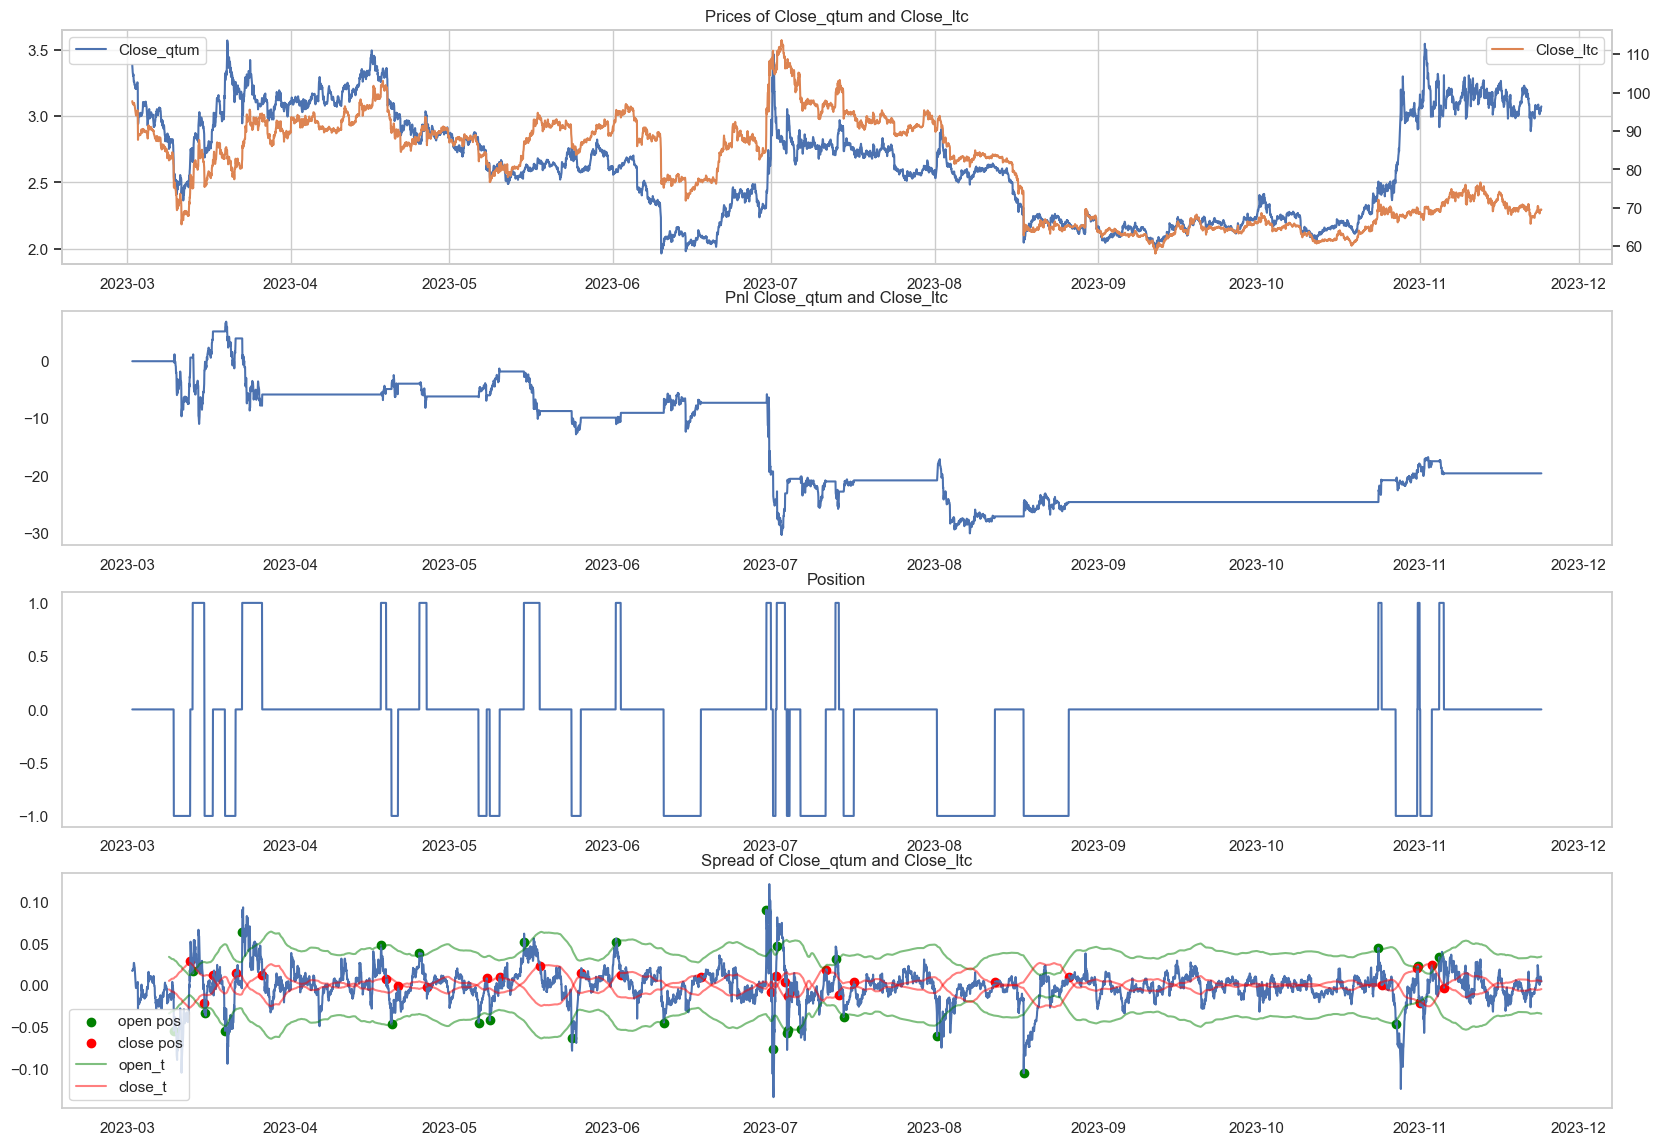

In [125]:
amount = 1
weight = 1

window = 24 * 7
k_open = 0.04
k_close = 0.001

for pair in pairs:
    rolling_spread = test[f'spread_kalman'].rolling(window=window)

    open_t = rolling_spread.mean() + k_open
    close_t = rolling_spread.mean() + k_close

    test[f'open_t'] = open_t
    test[f'close_t'] = close_t

for pair in pairs:
    total_df = run_pair_strategy(test, [pair[1], pair[0]], f'spread_kalman', amount, w, pair_strategy_modified, 
                                [f'open_t', f'close_t'], verbose=True, viz=True)

Validation

final_pnl ('Close_ltc', 'Close_qtum'): -21.576
pnl_per_day: -0.2397
trades: 10
max_dd: 24.343
sharpe_ratio: -3.3826
pnl_to_max_dd: -0.8863


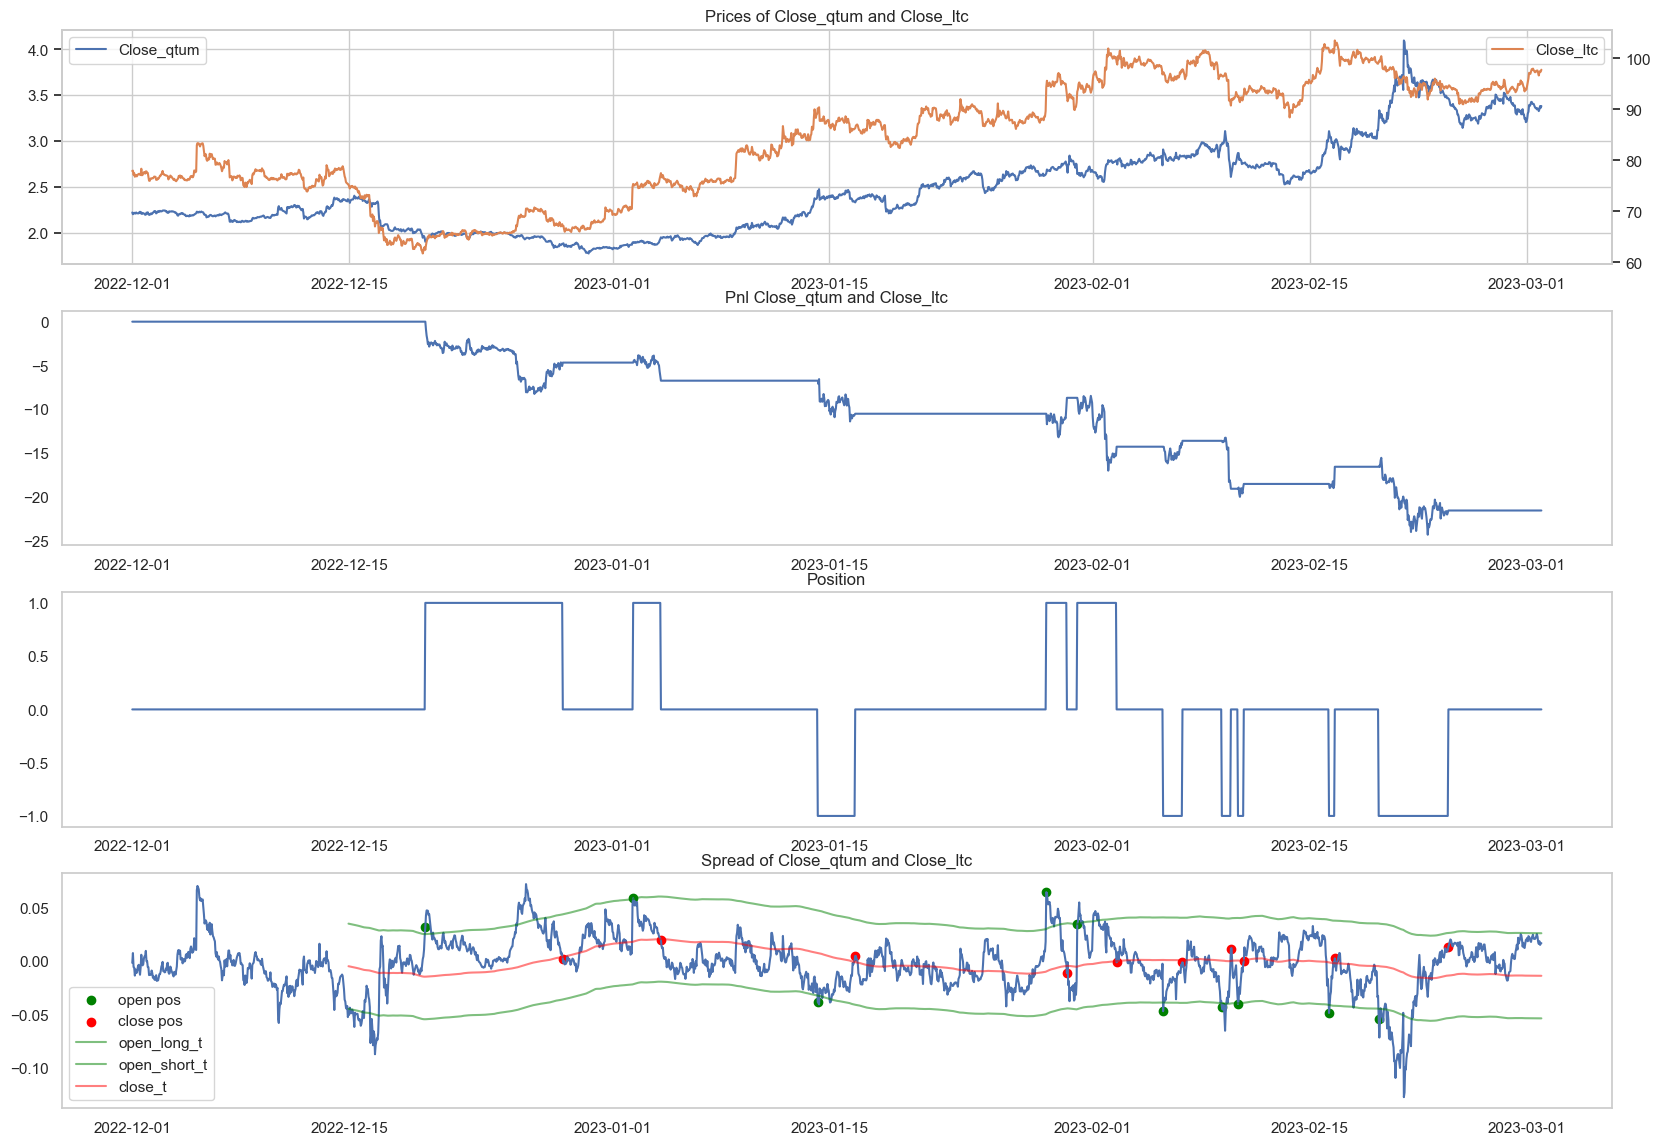

In [126]:
amount = 1
weight = 1

window = 24 * 14
k_open = 0.04
k_close = 0

for pair in pairs:
    rolling_spread = validation[f'spread_kalman'].rolling(window=window)

    open_long_t = rolling_spread.mean() + k_open
    open_short_t = rolling_spread.mean() - k_open
    close_t = rolling_spread.mean() + k_close


    validation[f'open_long_t'] = open_long_t
    validation[f'open_short_t'] = open_short_t
    validation[f'close_t'] = close_t

for pair in pairs:
    total_df = run_pair_strategy(validation, [pair[1], pair[0]], f'spread_kalman', amount, w, pair_strategy_2_modified, 
                                [f'open_long_t', f'open_short_t', 
                                f'close_t'], verbose=True, viz=True)

Test

final_pnl ('Close_ltc', 'Close_qtum'): -25.055
pnl_per_day: -0.0938
trades: 25
max_dd: 37.81
sharpe_ratio: -1.124
pnl_to_max_dd: -0.6627


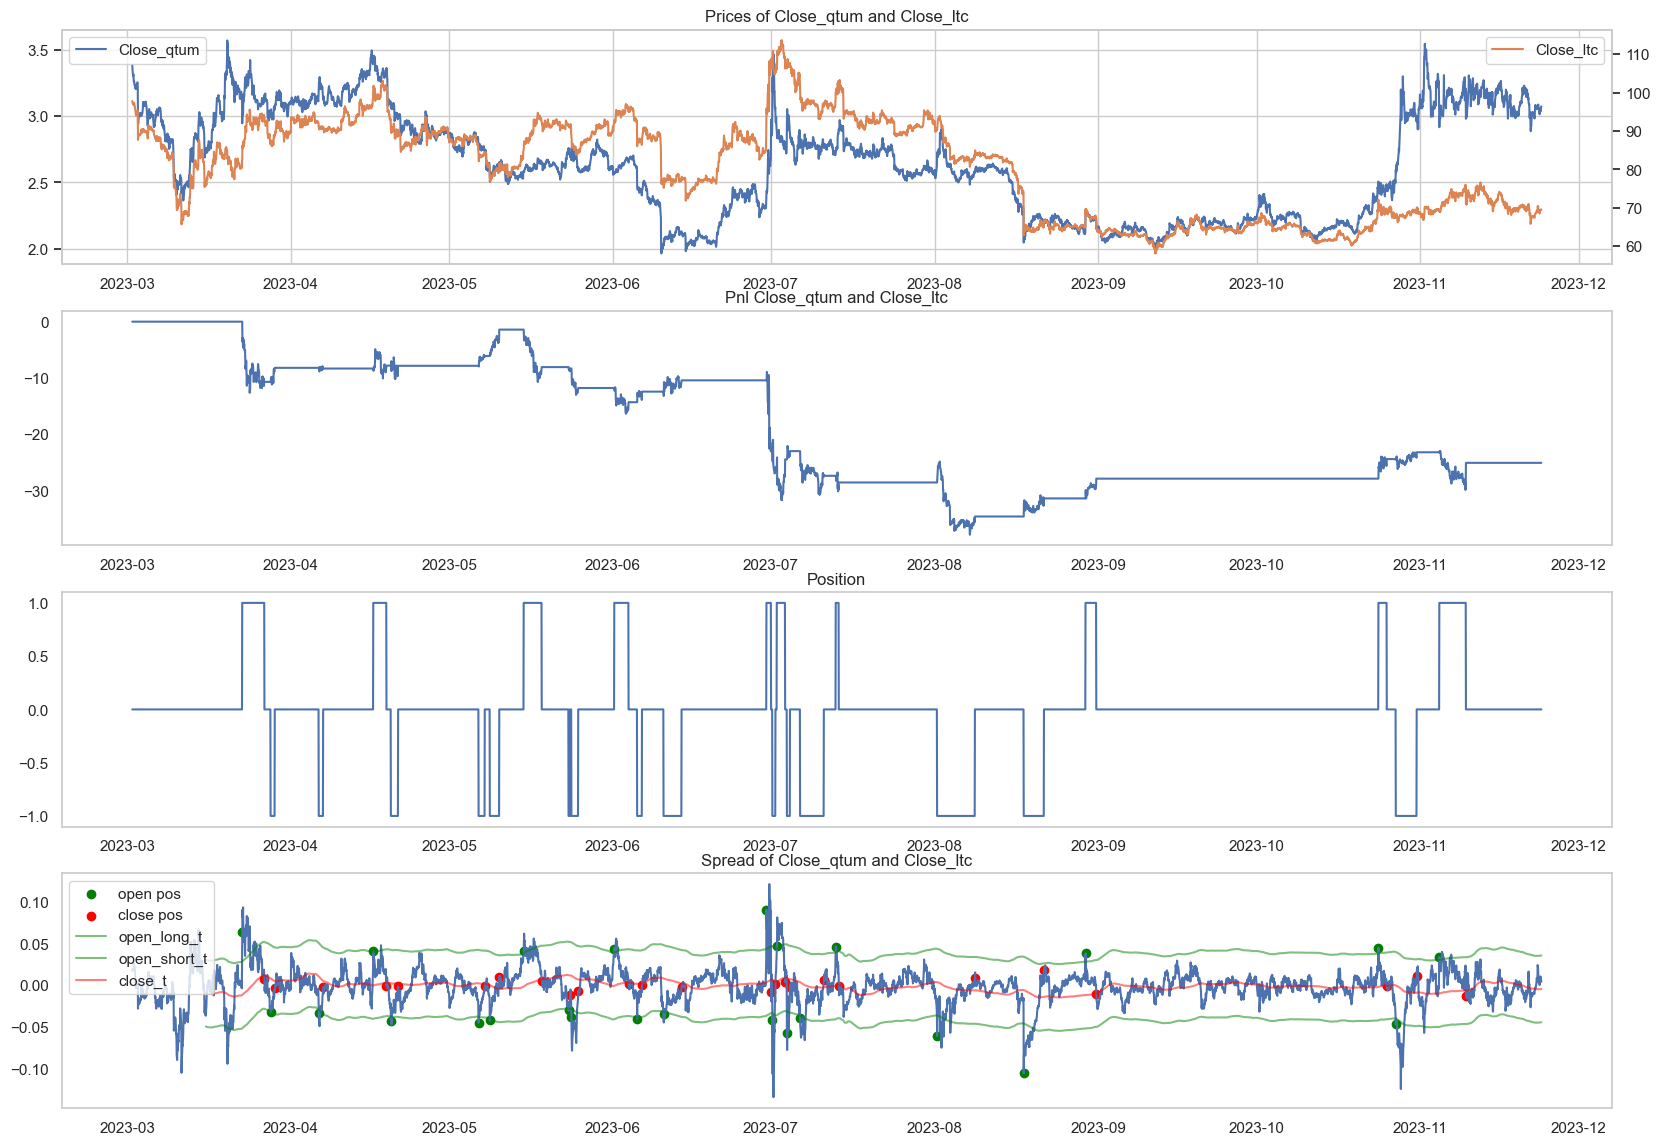

In [127]:
amount = 1
weight = 1

window = 24 * 14
k_open = 0.04
k_close = 0

for pair in pairs:
    rolling_spread = test[f'spread_kalman'].rolling(window=window)

    open_long_t = rolling_spread.mean() + k_open
    open_short_t = rolling_spread.mean() - k_open
    close_t = rolling_spread.mean() + k_close


    test[f'open_long_t'] = open_long_t
    test[f'open_short_t'] = open_short_t
    test[f'close_t'] = close_t

for pair in pairs:
    total_df = run_pair_strategy(test, [pair[1], pair[0]], f'spread_kalman', amount, w, pair_strategy_2_modified, 
                                [f'open_long_t', f'open_short_t', 
                                f'close_t'], verbose=True, viz=True)

### Cross-validation

In [128]:
import pykalman
from pykalman import KalmanFilter
from tqdm import tqdm

In [129]:
y = train[f'{pair[0]}_log']
x = train[f'{pair[1]}_log']
# y = train['Close_btc_log']
# x = train['Close_eth_log']

delta = 1e-3
trans_cov = delta / (1 - delta) * np.eye(2) # How much random walk wiggles
obs_mat = np.expand_dims(np.vstack([[x], [np.ones(len(x))]]).T, axis=1)

kf = KalmanFilter(n_dim_obs=1, n_dim_state=2, # y is 1-dimensional, (alpha, beta) is 2-dimensional
                  initial_state_mean=[0.95,0.95],
                  initial_state_covariance=np.ones((2, 2)),# 2x2 matrix of ones for covariance matrix estimate
                  transition_matrices=np.eye(2),
                  observation_matrices=obs_mat,
                  observation_covariance=2,
                  transition_covariance=trans_cov)

state_means_gm, state_covs_gm = kf.filter(y.values)

y_new = validation[f'{pair[0]}_log'].values
x_new = validation[f'{pair[1]}_log'].values
# y_new = validation['Close_btc_log'].values
# x_new = validation['Close_eth_log'].values

spreads = []
predicted_spreads = []

first_spread = y_new[0] - state_means_gm[-1, 0] * x_new[0] - state_means_gm[-1, 1]
predicted_spreads.append(first_spread)

filtered_state_mean = state_means_gm[-1]
filtered_state_covariance = state_covs_gm[-1]


for t in tqdm(range(len(x_new) - 1)):
    obs_mat = np.array([[x_new[t], 1.0]]) # For current observation
    
    # Update Kalman filter
    filtered_state_mean, filtered_state_covariance = kf.filter_update(
        filtered_state_mean, filtered_state_covariance, observation=y_new[t], observation_matrix=obs_mat)

    current_spread = y_new[t] - (filtered_state_mean[0] * x_new[t] + filtered_state_mean[1])
    spreads.append(current_spread)

    predicted_spread_t1 = y_new[t + 1] - filtered_state_mean[0] * x_new[t + 1] - filtered_state_mean[1]
    predicted_spreads.append(predicted_spread_t1)

obs_mat = np.array([[x_new[len(x_new) - 1], 1.0]]) # For current observation
    
# Update Kalman filter
filtered_state_mean, filtered_state_covariance = kf.filter_update(
    filtered_state_mean, filtered_state_covariance, observation=y_new[len(y_new) - 1], observation_matrix=obs_mat)


y_new = test[f'{pair[0]}_log'].values
x_new = test[f'{pair[1]}_log'].values
# y_new = test['Close_btc_log'].values
# x_new = test['Close_eth_log'].values

spreads_test = []
predicted_spreads_test = []

# Use last state_mean to predict spread for current observation
first_spread_test = y_new[0] - filtered_state_mean[0] * x_new[0] - filtered_state_mean[1]
predicted_spreads_test.append(first_spread_test)

for t in tqdm(range(len(x_new) - 1)):
    obs_mat = np.array([[x_new[t], 1.0]])
    
    filtered_state_mean, filtered_state_covariance = kf.filter_update(
        filtered_state_mean, filtered_state_covariance, observation=y_new[t], observation_matrix=obs_mat)

    current_spread = y_new[t] - (filtered_state_mean[0] * x_new[t] + filtered_state_mean[1])
    spreads_test.append(current_spread)

    predicted_spread_t1 = y_new[t + 1] - filtered_state_mean[0] * x_new[t + 1] - filtered_state_mean[1]
    predicted_spreads_test.append(predicted_spread_t1)

validation['spread_kalman'] = predicted_spreads
test['spread_kalman'] = predicted_spreads_test

100%|██████████| 6406/6406 [00:06<00:00, 978.01it/s] 


We will consider cross-validation for strategy with half-life spread, because it had good results

In [130]:
halflife = half_life(validation['spread_kalman'].fillna(0))

In [131]:
def half_life(spread):
    
    spread_lag = spread.shift(1)
    spread_lag.iloc[0] = spread_lag.iloc[1]
    spread_ret = spread - spread_lag
    spread_ret.iloc[0] = spread_ret.iloc[1]
    spread_lag2 = sm.add_constant(spread_lag)
    model = sm.OLS(spread_ret,spread_lag2)
    res = model.fit()
    halflife = int(round(-np.log(2) / res.params[1],0))
    
    if halflife <= 0:
        halflife = 1
        
    return halflife

def pair_strategy_modified(curr_trade: list, pos: float, index: int, spread: pd.Series, data: pd.DataFrame, t_cols: list, spred_prev: pd.Series) -> tuple:
    testov = spred_prev
    if spread >= data[t_cols[0]][index] and pos == 0 and testov < data[t_cols[0]][index]:  # open long
        pos = amount
        desicion = 'open'
    elif spread <= -data[t_cols[0]][index] and pos == 0 and testov > -data[t_cols[0]][index]:  # open short
        pos = -amount
        desicion = 'open'
    elif (spread <= data[t_cols[1]][index] and pos > 0) or (spread >= -data[t_cols[1]][index] and pos < 0):  # close
        pos = 0
        desicion = 'close'
    else:
        desicion = 'hold'
    return desicion, pos

def run_pair_strategy(df: pd.DataFrame, price_cols: list, spread_col: str, amount: float, w, strategy: 'function', t_cols: list = None, type: str = None, verbose: bool = True, viz: bool = True, verbose_print: bool = True) -> tuple:
    if t_cols is None:
        t_cols = ['open_t', 'close_t']
    # spread_values = df[spread_col].to_numpy()
    
    # halflife = half_life(df[spread_col].fillna(0))
    # # calculate z-score with window = half life period
    meanSpread = df[spread_col].rolling(window=halflife).mean()
    stdSpread = df[spread_col].rolling(window=halflife).std()
    spread_values = (df[spread_col]-meanSpread)/stdSpread
    spread_values = spread_values.to_numpy()
    
    amounts_vector = np.array([amount, -w * amount])
    prices = df[price_cols].to_numpy()
    prices_to_order = prices * amounts_vector  # цены для покупки / продажи, учитывая сторону сделки

    # Need to delete
    if type == 'zscore':
        spread_values = zscore(df[spread_col])
    elif type == 'zscore_moving_average':
        ratios_mavg5 = df[spread_col].rolling(window=5, center=False).mean()
        ratios_mavg60 = df[spread_col].rolling(window=60, center=False).mean()
        std_60 = df[spread_col].rolling(window=60, center=False).std()
        spread_values = (ratios_mavg5 - ratios_mavg60)/std_60
    
    pnls = []
    open_pnls = []
    trades = []
    all_pos = []
    last_trade = None
    pos = 0
    prev_spread = 0

    for index, spread in enumerate(spread_values):
        curr_trade = prices_to_order[index]
        curr_opnl = 0
        curr_pnl = 0
        
        desicion, new_pos = strategy(curr_trade, pos, index, spread, df, t_cols, prev_spread)
        prev_spread = spread

        # считаем либо close pnl, либо open pnl
        if desicion == 'open':
            last_trade = curr_trade
            pos = new_pos
        elif desicion == 'close':
            curr_pnl = calc_pnl(last_trade, curr_trade, pos)
            last_trade = None
            pos = 0
        else:
            curr_opnl = calc_pnl(last_trade, curr_trade, pos)
        
        open_pnls.append(curr_opnl)
        pnls.append(curr_pnl)
        trades.append(desicion)
        all_pos.append(pos)
        

    pnls = np.array(pnls)
    open_pnls = np.array(open_pnls)
    trades = np.array(trades)
    
    total_df = df[price_cols].copy()
    total_df['pnl'] = pnls
    total_df['open_pnl'] = open_pnls
    total_df['trades'] = trades
    total_df['position'] = all_pos
    total_df['spread'] = df[spread_col]
    total_df['real_pnl'] = np.cumsum(pnls) + open_pnls
    total_df[t_cols] = df[t_cols]
    
    
    if verbose:
        final_pnl = total_df['real_pnl'].iloc[-1]
        pnl_per_day = final_pnl / (total_df.index[-1] - total_df.index[0]).days
        trades = (total_df['trades'] != 'hold').sum() // 2  # считаем одним трейдом пару открытие-закрытие позиции
        sharpe_ratio = calc_sharpe(total_df['real_pnl'])
        max_dd = calc_max_drawdown(total_df['real_pnl'])
        pnl_to_max_dd = final_pnl / max_dd
        summary = {f'final_pnl {pair}': final_pnl, 'pnl_per_day': pnl_per_day, 'trades': trades, 'max_dd': max_dd, 
                   'sharpe_ratio': sharpe_ratio, 'pnl_to_max_dd': pnl_to_max_dd}
        if verbose_print:
            print(*[f'{key}: {round(value, 4)}' for key, value in summary.items()], sep='\n')
    
    if viz:
        plot_results(total_df, price_cols, t_cols)
        
    return total_df, summary

In [132]:
halflife = half_life(validation['spread_kalman'].fillna(0))

In [133]:
halflife

19

In [134]:
def find_best_params(data):
    sharpe = 0
    pnl_to_drawdown = 0
    k_close = 0
    best_window = 0
    best_k_open = 0
    list_kopen = np.arange(0.001, 0.101, 0.001)
    for window_ in tqdm(range(1, 15)):
        for k_open_ in tqdm(list_kopen):
            amount = 1
            weight = 1

            window = 24 * window_
            for pair in pairs:
                rolling_spread = data[f'spread_kalman'].rolling(window=window)

                open_t = rolling_spread.mean() + k_open_
                close_t = rolling_spread.mean() + k_close

                data[f'open_t'] = open_t
                data[f'close_t'] = close_t

            for pair in pairs:
                _, summary = run_pair_strategy(data, [pair[1], pair[0]], f'spread_kalman', amount, weight, pair_strategy_modified, 
                                            [f'open_t', f'close_t'], verbose=True, viz=False, verbose_print=False)
            
            sharpe_ratio = summary['sharpe_ratio']
            # print(sharpe_ratio)
            drawdown = summary['pnl_to_max_dd']
            # print(drawdown)
            if drawdown > pnl_to_drawdown and sharpe_ratio > sharpe:
                sharpe = sharpe_ratio
                pnl_to_drawdown = drawdown
                best_window = window_
                best_k_open = k_open_
                # print(sharpe, pnl_to_drawdown, best_k_open, best_window)
    
    
    return best_window, best_k_open

In [136]:
best_window, best_k_open = find_best_params(validation)

100%|██████████| 14/14 [04:37<00:00, 19.85s/it]


(6, 0.07200000000000001)

final_pnl ('Close_ltc', 'Close_qtum'): 53.227
pnl_per_day: 0.5914
trades: 160
max_dd: 12.0
sharpe_ratio: 5.652
pnl_to_max_dd: 4.4356


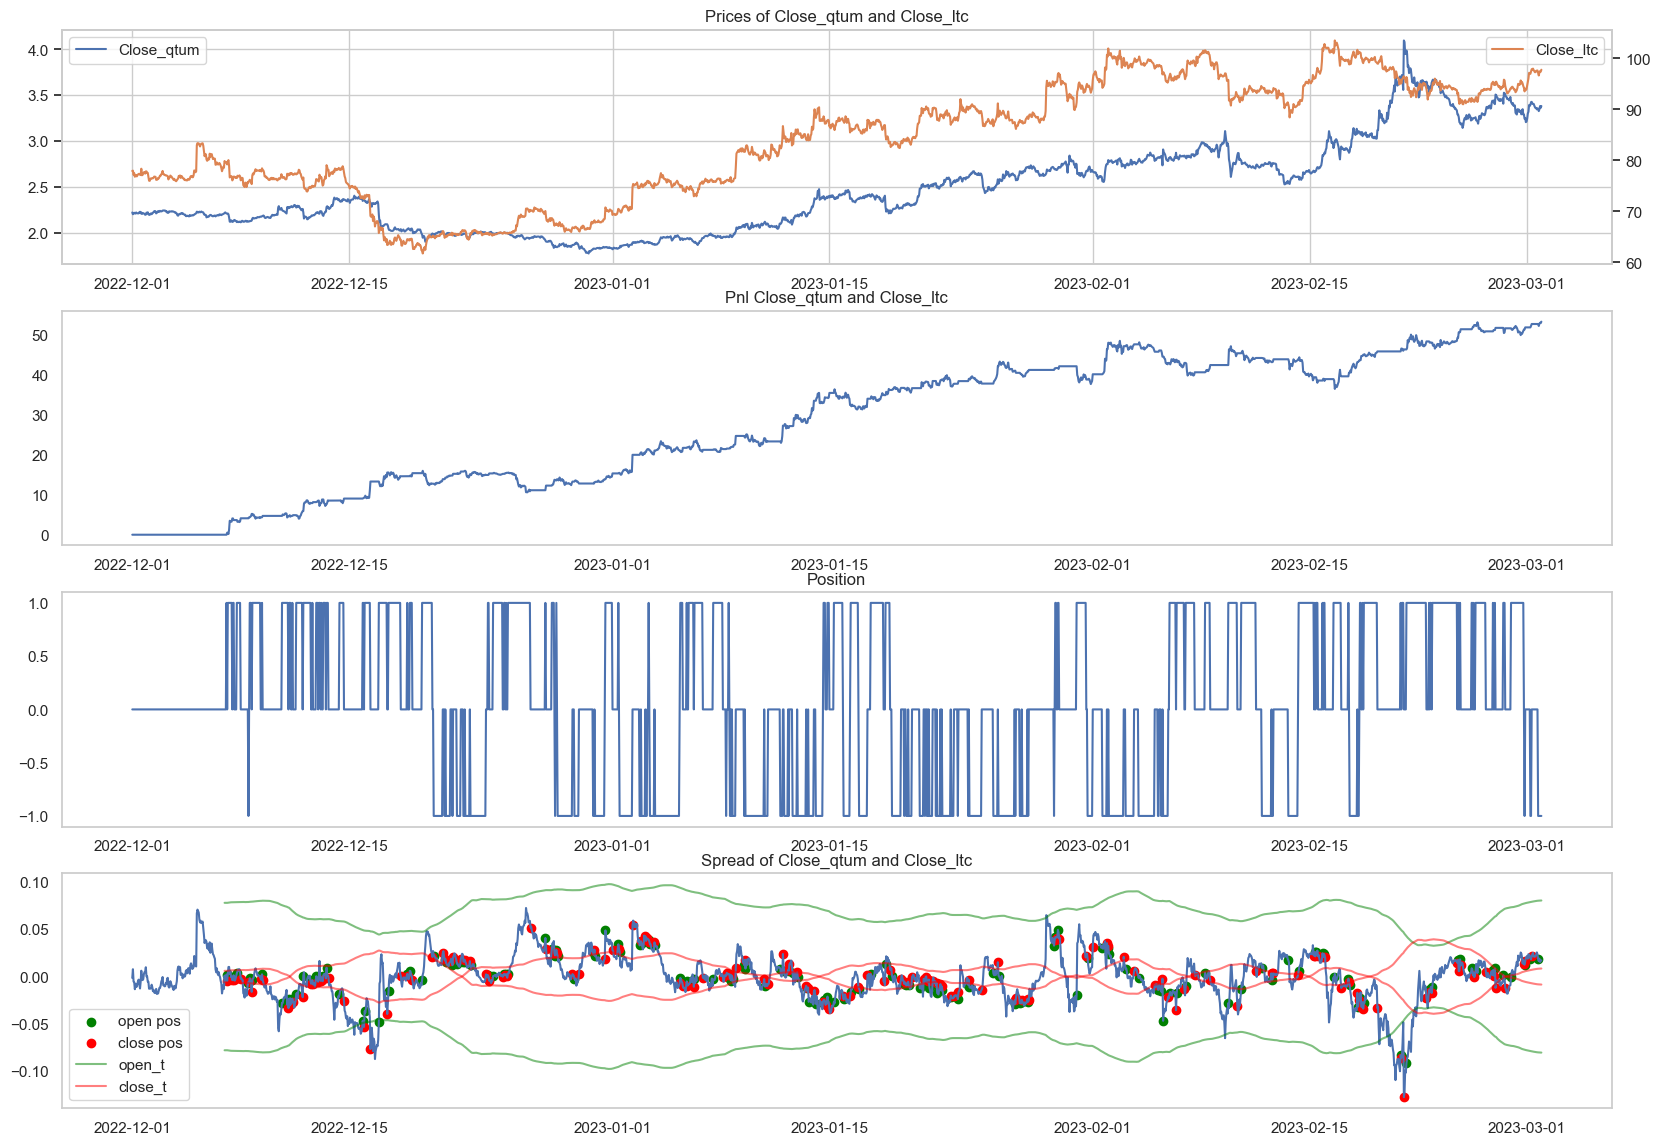

In [138]:
amount = 1
weight = 1
w = 1

window = 24 * best_window
k_open = best_k_open
k_close = 0

# amount = 1
# weight = 1

# window = 24 * 14
# k_open = 0.02
# k_close = 0.02

for pair in pairs:
    rolling_spread = validation[f'spread_kalman'].rolling(window=window)

    open_t = rolling_spread.mean() + k_open
    close_t = rolling_spread.mean() + k_close

    validation[f'open_t'] = open_t
    validation[f'close_t'] = close_t

for pair in pairs:
    total_df = run_pair_strategy(validation, [pair[1], pair[0]], f'spread_kalman', amount, w, pair_strategy_modified, 
                                [f'open_t', f'close_t'], verbose=True, viz=True)

Test

final_pnl ('Close_ltc', 'Close_qtum'): 45.471
pnl_per_day: 0.1703
trades: 450
max_dd: 21.285
sharpe_ratio: 1.5863
pnl_to_max_dd: 2.1363


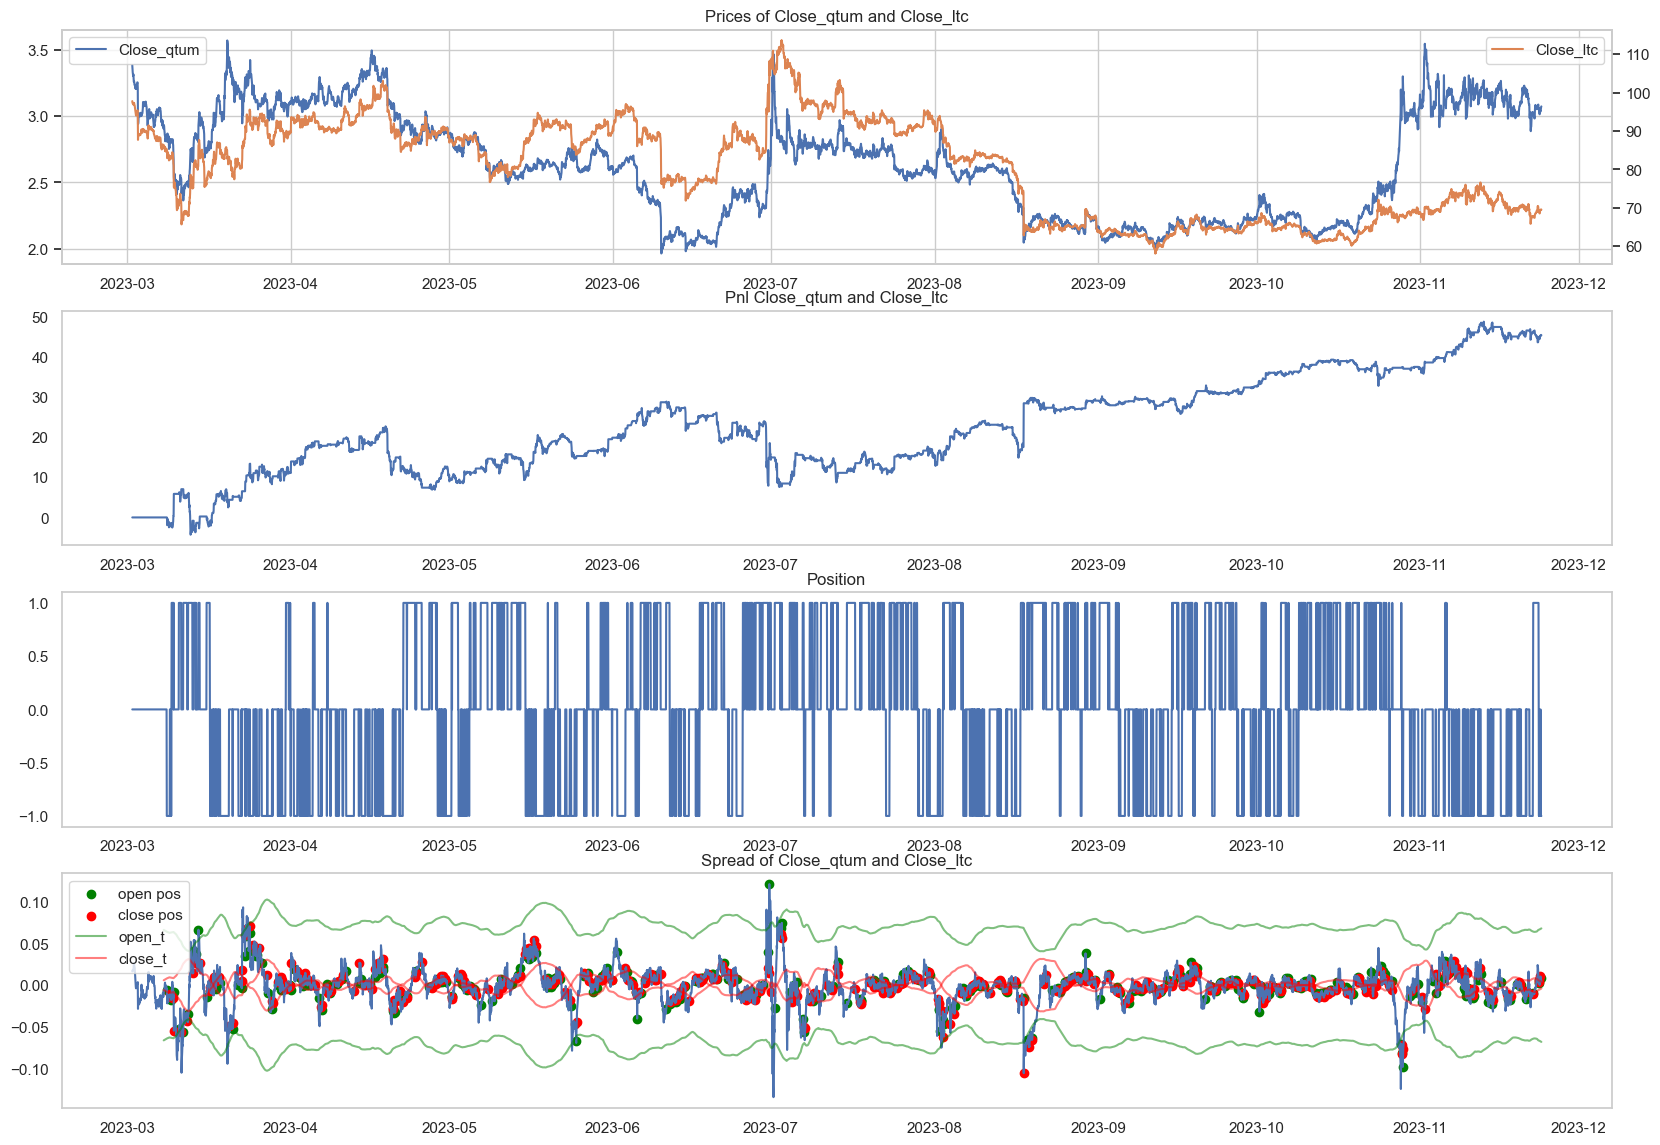

In [140]:
amount = 1
weight = 1

window = 24 * best_window
k_open = best_k_open
k_close = 0

# amount = 1
# weight = 1

# window = 24 * 14
# k_open = 0.02
# k_close = 0.02

for pair in pairs:
    rolling_spread = test[f'spread_kalman'].rolling(window=window)

    open_t = rolling_spread.mean() + k_open
    close_t = rolling_spread.mean() + k_close

    test[f'open_t'] = open_t
    test[f'close_t'] = close_t

for pair in pairs:
    total_df = run_pair_strategy(test, [pair[1], pair[0]], f'spread_kalman', amount, w, pair_strategy_modified, 
                                [f'open_t', f'close_t'], verbose=True, viz=True)

Then we will perfom a TimeSeriesSplit

In [141]:
from sklearn.model_selection import TimeSeriesSplit

In [142]:
tscv = TimeSeriesSplit(n_splits=10)
summaries_validation = []
summaries_test = []
indices = []
for i, (train_index, test_index) in enumerate(tscv.split(df)):
    indices.append([train_index, test_index])
    train = df.iloc[:train_index[-1] - 2000 + 1]
    validation = df.iloc[train_index[-1] - 2000: train_index[-1] + 1]
    test = df.iloc[train_index[-1] : test_index[-1]]
    
    y = train[f'{pair[0]}_log']
    x = train[f'{pair[1]}_log']

    delta = 1e-3
    trans_cov = delta / (1 - delta) * np.eye(2) # How much random walk wiggles
    obs_mat = np.expand_dims(np.vstack([[x], [np.ones(len(x))]]).T, axis=1)

    kf = KalmanFilter(n_dim_obs=1, n_dim_state=2, # y is 1-dimensional, (alpha, beta) is 2-dimensional
                    initial_state_mean=[0.95,0.95],
                    initial_state_covariance=np.ones((2, 2)),# 2x2 matrix of ones for covariance matrix estimate
                    transition_matrices=np.eye(2),
                    observation_matrices=obs_mat,
                    observation_covariance=2,
                    transition_covariance=trans_cov)

    state_means_gm, state_covs_gm = kf.filter(y.values)

    y_new = validation[f'{pair[0]}_log'].values
    x_new = validation[f'{pair[1]}_log'].values

    spreads = []
    predicted_spreads = []

    first_spread = y_new[0] - state_means_gm[-1, 0] * x_new[0] - state_means_gm[-1, 1]
    predicted_spreads.append(first_spread)

    filtered_state_mean = state_means_gm[-1]
    filtered_state_covariance = state_covs_gm[-1]

    print('Kalman filter on validation')
    for t in tqdm(range(len(x_new) - 1)):
        obs_mat = np.array([[x_new[t], 1.0]]) # For current observation
        
        # Update Kalman filter
        filtered_state_mean, filtered_state_covariance = kf.filter_update(
            filtered_state_mean, filtered_state_covariance, observation=y_new[t], observation_matrix=obs_mat)

        current_spread = y_new[t] - (filtered_state_mean[0] * x_new[t] + filtered_state_mean[1])
        spreads.append(current_spread)

        predicted_spread_t1 = y_new[t + 1] - filtered_state_mean[0] * x_new[t + 1] - filtered_state_mean[1]
        predicted_spreads.append(predicted_spread_t1)
    print('Kalman filter on validation: Done!!!')

    y_new = test[f'{pair[0]}_log'].values
    x_new = test[f'{pair[1]}_log'].values

    spreads_test = []
    predicted_spreads_test = []

    # Use last state_mean to predict spread for current observation
    first_spread = y_new[0] - filtered_state_mean[0] * x_new[0] - filtered_state_mean[1]
    predicted_spreads_test.append(first_spread)

    print('Kalman filter on test')
    for t in tqdm(range(len(x_new) - 1)):
        obs_mat = np.array([[x_new[t], 1.0]])
        
        filtered_state_mean, filtered_state_covariance = kf.filter_update(
            filtered_state_mean, filtered_state_covariance, observation=y_new[t], observation_matrix=obs_mat)

        current_spread = y_new[t] - (filtered_state_mean[0] * x_new[t] + filtered_state_mean[1])
        spreads_test.append(current_spread)

        predicted_spread_t1 = y_new[t + 1] - filtered_state_mean[0] * x_new[t + 1] - filtered_state_mean[1]
        predicted_spreads_test.append(predicted_spread_t1)

    print('Kalman filter on test: Done!!!')

    validation['spread_kalman'] = predicted_spreads
    test['spread_kalman'] = predicted_spreads_test

    halflife = half_life(validation['spread_kalman'].fillna(0))

    print('Find best params')
    best_window, best_kopen = find_best_params(validation)
    print('Find best params: Done!')

    amount = 1
    weight = 1

    window = 24 * best_window
    k_open = best_kopen
    k_close = 0

    # amount = 1
    # weight = 1

    # window = 24 * 14
    # k_open = 0.02
    # k_close = 0.02

    for pair in pairs:
        rolling_spread = validation[f'spread_kalman'].rolling(window=window)

        open_t = rolling_spread.mean() + k_open
        close_t = rolling_spread.mean() + k_close

        validation[f'open_t'] = open_t
        validation[f'close_t'] = close_t

    for pair in pairs:
        _, summary = run_pair_strategy(validation, [pair[1], pair[0]], f'spread_kalman', amount, w, pair_strategy_modified, 
                                    [f'open_t', f'close_t'], verbose=True, viz=False, verbose_print=False)
    summaries_validation.append(summary)

    for pair in pairs:
        rolling_spread = test[f'spread_kalman'].rolling(window=window)

        open_t = rolling_spread.mean() + k_open
        close_t = rolling_spread.mean() + k_close

        test[f'open_t'] = open_t
        test[f'close_t'] = close_t

    for pair in pairs:
        _, summary = run_pair_strategy(test, [pair[1], pair[0]], f'spread_kalman', amount, w, pair_strategy_modified, 
                                    [f'open_t', f'close_t'], verbose=True, viz=False, verbose_print=False)
    summaries_test.append(summary)
    print(f'Done on fold {i}!')
    print('\n')
    

Kalman filter on validation


100%|██████████| 2000/2000 [00:01<00:00, 1557.63it/s]


Kalman filter on validation: Done!!!
Kalman filter on test


100%|██████████| 3861/3861 [00:02<00:00, 1604.54it/s]


Kalman filter on test: Done!!!
Find best params


100%|██████████| 14/14 [05:08<00:00, 22.01s/it]


Find best params: Done!
Done on fold 0!


Kalman filter on validation


100%|██████████| 2000/2000 [00:01<00:00, 1443.39it/s]


Kalman filter on validation: Done!!!
Kalman filter on test


100%|██████████| 3861/3861 [00:02<00:00, 1585.61it/s]


Kalman filter on test: Done!!!
Find best params


100%|██████████| 14/14 [04:17<00:00, 18.42s/it]


Find best params: Done!
Done on fold 1!


Kalman filter on validation


100%|██████████| 2000/2000 [00:01<00:00, 1545.55it/s]


Kalman filter on validation: Done!!!
Kalman filter on test


100%|██████████| 3861/3861 [00:02<00:00, 1547.48it/s]


Kalman filter on test: Done!!!
Find best params


100%|██████████| 14/14 [04:28<00:00, 19.20s/it]


Find best params: Done!
Done on fold 2!


Kalman filter on validation


100%|██████████| 2000/2000 [00:01<00:00, 1302.05it/s]


Kalman filter on validation: Done!!!
Kalman filter on test


100%|██████████| 3861/3861 [00:02<00:00, 1311.02it/s]


Kalman filter on test: Done!!!
Find best params


100%|██████████| 14/14 [05:08<00:00, 22.06s/it]


Find best params: Done!
Done on fold 3!


Kalman filter on validation


100%|██████████| 2000/2000 [00:01<00:00, 1279.59it/s]


Kalman filter on validation: Done!!!
Kalman filter on test


100%|██████████| 3861/3861 [00:03<00:00, 1107.89it/s]


Kalman filter on test: Done!!!
Find best params


100%|██████████| 14/14 [04:31<00:00, 19.38s/it]


Find best params: Done!
Done on fold 4!


Kalman filter on validation


100%|██████████| 2000/2000 [00:01<00:00, 1328.02it/s]


Kalman filter on validation: Done!!!
Kalman filter on test


100%|██████████| 3861/3861 [00:02<00:00, 1300.86it/s]


Kalman filter on test: Done!!!
Find best params


100%|██████████| 14/14 [05:09<00:00, 22.12s/it]


Find best params: Done!
Done on fold 5!


Kalman filter on validation


100%|██████████| 2000/2000 [00:01<00:00, 1247.63it/s]


Kalman filter on validation: Done!!!
Kalman filter on test


100%|██████████| 3861/3861 [00:03<00:00, 1176.76it/s]


Kalman filter on test: Done!!!
Find best params


100%|██████████| 14/14 [05:04<00:00, 21.76s/it]


Find best params: Done!
Done on fold 6!


Kalman filter on validation


100%|██████████| 2000/2000 [00:01<00:00, 1502.59it/s]


Kalman filter on validation: Done!!!
Kalman filter on test


100%|██████████| 3861/3861 [00:02<00:00, 1465.26it/s]


Kalman filter on test: Done!!!
Find best params


100%|██████████| 14/14 [04:55<00:00, 21.08s/it]


Find best params: Done!
Done on fold 7!


Kalman filter on validation


100%|██████████| 2000/2000 [00:01<00:00, 1529.58it/s]


Kalman filter on validation: Done!!!
Kalman filter on test


100%|██████████| 3861/3861 [00:02<00:00, 1465.44it/s]


Kalman filter on test: Done!!!
Find best params


100%|██████████| 14/14 [04:45<00:00, 20.38s/it]


Find best params: Done!
Done on fold 8!


Kalman filter on validation


100%|██████████| 2000/2000 [00:01<00:00, 1569.86it/s]


Kalman filter on validation: Done!!!
Kalman filter on test


100%|██████████| 3861/3861 [00:02<00:00, 1576.60it/s]


Kalman filter on test: Done!!!
Find best params


100%|██████████| 14/14 [04:23<00:00, 18.84s/it]


Find best params: Done!
Done on fold 9!




In [151]:
pnl_valid = 0
pnl_per_day_valid = 0
sharpe_valid = 0
pnl_to_max_dd_valid = 0

pnl_test = 0
pnl_per_day_test = 0
sharpe_test = 0
pnl_to_max_dd_test = 0
for i in range(10):
    # print(f'Results for {i}-th Fold')
    # print(summaries_validation[i], summaries_test[i])
    # print('\n')
    pnl_valid += summaries_validation[i][f"final_pnl ('{pair[0]}', '{pair[1]}')"]
    pnl_per_day_valid += summaries_validation[i]['pnl_per_day']
    sharpe_valid += summaries_validation[i]['sharpe_ratio']
    pnl_to_max_dd_valid += summaries_validation[i]['pnl_to_max_dd']

    pnl_test += summaries_test[i][f"final_pnl ('{pair[0]}', '{pair[1]}')"]
    pnl_per_day_test += summaries_test[i]['pnl_per_day']
    sharpe_test += summaries_test[i]['sharpe_ratio']
    pnl_to_max_dd_test += summaries_test[i]['pnl_to_max_dd']

pnl_valid /= 10
pnl_per_day_valid /= 10
sharpe_valid /= 10
pnl_to_max_dd_valid /= 10

pnl_test /= 10
pnl_per_day_test /= 10
sharpe_test /= 10
pnl_to_max_dd_test /= 10

# print(pnl_valid, pnl_per_day_valid, sharpe_valid, pnl_to_max_dd_valid)
# print(pnl_test, pnl_per_day_test, sharpe_test, pnl_to_max_dd_test)
print("average PNL validation: ", pnl_valid)
print("average Sharpe validatio: ", sharpe_valid)
print("average PNL to MAXDD validation: ", pnl_to_max_dd_valid)

print("average PNL test: ", pnl_test)
print("average Sharpe test: ", sharpe_test)
print("average PNL to MAXDD test: ", pnl_to_max_dd_test)

average PNL validation:  57.92440000000006
average Sharpe validatio:  4.470239051709743
average PNL to MAXDD validation:  4.4479991985027665
average PNL test:  43.006700000000066
average Sharpe test:  1.5378351442781049
average PNL to MAXDD test:  1.6989295551294656


Average sharpe on validation: 4.47
Average sharpe on test: 1.53


Average pnl_to_dd on validation: 4.47
Average pnl_to_dd on test: 1.69